In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
from divers import plot_confusion_matrix

In [5]:
import sys
sys.path.append('./sompyLatmos/')     # Chemin du package
from sompy import SOMFactory
from sompy import SOMData

### Chargement et mise en forme des données

Chargement des différents jeux de représentation

In [6]:
# les imagettes 
x = np.loadtxt("./donnees/x.txt")
x_comp_names = [ "x["+str(i)+"]" for i in range(x.shape[0])]
#
# différentes projections des imagettes
hx = np.loadtxt("./donnees/hx.txt")
hx_comp_names = [ "hx["+str(i)+"]" for i in range(hx.shape[0])]
hy_comp_names = [ "hy["+str(i)+"]" for i in range(hx.shape[0])]
#
hx_hy = np.loadtxt("./donnees/hx_hy.txt")
hx_hy_comp_names = []
hx_hy_comp_names.extend(hx_comp_names)
hx_hy_comp_names.extend(hy_comp_names)
#
pb_comp_names = [ "pb["+str(i)+"]" for i in range(hx.shape[0])]
ph_comp_names = [ "ph["+str(i)+"]" for i in range(hx.shape[0])]
pb_ph = np.loadtxt("./donnees/pb_ph.txt")
pb_ph_comp_names = []
pb_ph_comp_names.extend(pb_comp_names)
pb_ph_comp_names.extend(ph_comp_names)
#
pg_comp_names = [ "pg["+str(i)+"]" for i in range(hx.shape[0])]
pd_comp_names = [ "pd["+str(i)+"]" for i in range(hx.shape[0])]
pg_pd = np.loadtxt("./donnees/pg_pd.txt")
pg_pd_comp_names = []
pg_pd_comp_names.extend(pg_comp_names)
pg_pd_comp_names.extend(pd_comp_names)
#
# combinaisons de projections
hx_hy_pb_ph = np.loadtxt("./donnees/hx_hy_pb_ph.txt")
hx_hy_pb_ph_comp_names = []
hx_hy_pb_ph_comp_names.extend(hx_hy_comp_names)
hx_hy_pb_ph_comp_names.extend(pb_ph_comp_names)
#
hx_hy_pg_pd = np.loadtxt("./donnees/hx_hy_pg_pd.txt")
hx_hy_pg_pd_comp_names = []
hx_hy_pg_pd_comp_names.extend(hx_hy_comp_names)
hx_hy_pg_pd_comp_names.extend(pg_pd_comp_names)


**Choix d'une représentation des données** 

In [7]:
#strChoix = 'x' problematique en théorie et en pratique
#strChoix = 'hx'
#strChoix = 'hx_hy'
#strChoix = 'pb_ph'
#strChoix = 'pg_pd'
#strChoix = 'hx_hy_pb_ph'
strChoix = 'hx_hy_pg_pd'
if strChoix == 'x':
    data = x.T
    comp_names = x_comp_names
elif strChoix == 'hx':
    data = hx.T
    comp_names = hx_comp_names
elif strChoix == 'hx_hy':
    data = hx_hy.T
    comp_names = hx_hy_comp_names
elif strChoix == 'pb_ph':
    data = pb_ph.T
    comp_names = pb_ph_comp_names
elif strChoix == 'pg_pd':
    data = pg_pd.T
    comp_names = pg_pd_comp_names
elif strChoix == 'hx_hy_pb_ph':
    data = hx_hy_pb_ph.T
    comp_names = hx_hy_pb_ph_comp_names
elif strChoix == 'hx_hy_pg_pd':
    data = hx_hy_pg_pd.T
    comp_names = hx_hy_pg_pd_comp_names
else:
    raise ValueError('choix inattendu')
masque=np.ones(len(comp_names))
#del x, hx, hx_hy, pb_ph, pg_pd, hx_hy_pb_ph, hx_hy_pg_pd
encodage_name= ['hx_hy','pg_pd','hx_hy_pg_pd']
encodage =  [hx_hy.T,pg_pd.T,hx_hy_pg_pd.T]
composante_names = [hx_hy_comp_names,pg_pd_comp_names,hx_hy_pg_pd_comp_names]

Ici on a aussi les étiquettes correspondant à chacune des données. On les utilisera par la suite pour voir les performances de **l'algorithme qui est on le rappelle non supervisé**.   
On se servira de ces etiquettes pour évaluer la qualité du "résumé numérique" fourni par la carte topologique.

In [8]:
t = np.loadtxt("./donnees/t.txt").T
t[np.where(t==-1)] = 0
t_label_num = np.where(t==1)[1]
classnames = ['zero','un','deux','trois','quatre','cinq','six','sept','huit','neuf']
reverse_classnames =  {'zero':0,'un':1,'deux':2,'trois':3,'quatre':4,'cinq':5,'six':6,'sept':7,'huit':8,'neuf':9,'Nan':-1}
data_labels = [ classnames[i] for i in t_label_num]
data_labels =  np.array(data_labels)

Ici, on va mettre quelques données de coté pour évaluer les performances de l'apprentissage. Notamment pour évaluer la capacité de la partition réalisée par la carte en terme de classification des chiffres manuscrits.
Là encore, on rappelle que l'algorithme est non supervisé. Les étiquettes '`t`) ne sont pas prises en compte. Lors de l'apprentissage. La partition de la carte sera basée uniquement sur les données apprises (`X`). 
On évaluera la capacité de la carte à exploiter l'information fournie dans `X`.

In [9]:
N = 34*10
# rescale the data, use the traditional train/test split
#data, data_ = data[:N,:], data[N:,:]
#t_label_num, t_label_num_ = t_label_num[:N], t_label_num[N:]
#data_labels,data_labels_ = np.array(data_labels[:N]), np.array(data_labels[N:])
#data.shape

In [10]:
from sklearn.model_selection import train_test_split

data_dev, data_test, data_labels_dev, data_labels_test = train_test_split(data, data_labels, test_size=0.15, random_state=42)
data_train, data_val, data_labels_train, data_labels_val = train_test_split(data_dev, data_labels_dev, test_size=0.15, random_state=42)


**Création d'un objet sData**

In [11]:
sData_train = SOMData(data_train,      # les données 
                comp_names,# les noms des variables
                data_labels_train)

**Affichage des T-SNE**

In [23]:
#sData.plot_tsne()
import itertools

epochs= np.arange(10,120,25)
tmp_phase1=np.arange(2,10,2)
tmp_phase2=np.arange(0.3,3,0.3)

#epochs= [1]
#tmp_phase1=[1]
#tmp_phase2=[1]
len(list(itertools.product(epochs,tmp_phase1,tmp_phase2)))

140

### Création de la carte et apprentissage

#### Création d'une carte topologique (objet sm)

In [13]:
#mapsize=(10,1)
mapsize=(12,12)
#mapsize=(10,10)
#mapsize=(3,7)
sm = SOMFactory().build(sData_train, 
                        mapsize=mapsize,
                        normalization = None, 
                        #initialization='random', # obligatoire pour x
                        initialization='pca',  
                        radius_train ='linear', 
                        name='Des Chiffres',
                        #lattice='rect',
                        lattice='hexa',
                        mask=masque,
                        components_to_plot=((0,1),(0,2),(1,2)))

#### Entraînement de la carte

In [14]:
'''
sm.train(n_job=1, 
         verbose=None, 
         train_rough_len=30, 
         train_rough_radiusin=3,
         train_rough_radiusfin=1,
         train_finetune_len=30,
         train_finetune_radiusin=2.5,
         train_finetune_radiusfin=0.25,
         watch_evolution = False)'''

'\nsm.train(n_job=1, \n         verbose=None, \n         train_rough_len=30, \n         train_rough_radiusin=3,\n         train_rough_radiusfin=1,\n         train_finetune_len=30,\n         train_finetune_radiusin=2.5,\n         train_finetune_radiusfin=0.25,\n         watch_evolution = False)'

In [15]:
#np.where(data_labels_estim[:,None]==np.array(classnames)[None,:])
#data_labels_estim

In [16]:
#np.where(data_labels_estim[:,None]==np.array(classnames_)[None,:])[1]  
#np.array([reverse_classnames[x] for x in data_labels_estim]).shape

In [17]:
#np.where(data_labels_estim[:,None]==np.array(classnames_)[None,:])[1].shape

0it [00:00, ?it/s]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1379  tErr : 0.7803
Epoch : 2 qErr : 0.1354  tErr : 0.7832
Epoch : 3 qErr : 0.1333  tErr : 0.7890
Epoch : 4 qErr : 0.1315  tErr : 0.7919
Epoch : 5 qErr : 0.1298  tErr : 0.7746
Epoch : 6 qErr : 0.1281  tErr : 0.7775
Epoch : 7 qErr : 0.1260  tErr : 0.7746
Epoch : 8 qErr : 0.1237  tErr : 0.7717
Epoch : 9 qErr : 0.1216  tErr : 0.7775


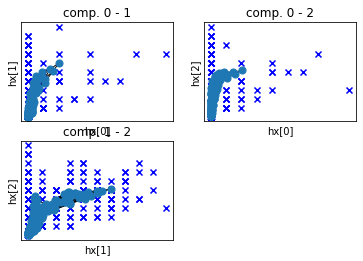

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0804  tErr : 0.7746
Epoch : 1 qErr : 0.0704  tErr : 0.7919
Epoch : 2 qErr : 0.0682  tErr : 0.7861
Epoch : 3 qErr : 0.0678  tErr : 0.7919
Epoch : 4 qErr : 0.0677  tErr : 0.7919
Epoch : 5 qErr : 0.0677  tErr : 0.7919
Epoch : 6 qErr : 0.0677  tErr : 0.7919
Epoch : 7 qErr : 0.0677  tErr : 0.7919
Epoch : 8 qErr : 0.0677  tErr : 0.7919
Epoch : 9 qErr : 0.0677  tErr : 0.7919


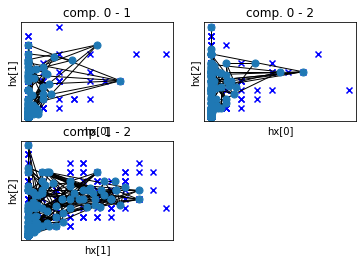

1it [00:13, 13.27s/it]

new best score 0.6935483870967742
new best config {'epochs': 10, 't_pahse1': 2, 't_phase2': 0, 't_pahse2': 0.3}
Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1379  tErr : 0.7803
Epoch : 2 qErr : 0.1354  tErr : 0.7832
Epoch : 3 qErr : 0.1333  tErr : 0.7890
Epoch : 4 qErr : 0.1315  tErr : 0.7919
Epoch : 5 qErr : 0.1298  tErr : 0.7746
Epoch : 6 qErr : 0.1281  tErr : 0.7775
Epoch : 7 qErr : 0.1260  tErr : 0.7746
Epoch : 8 qErr : 0.1237  tErr : 0.7717
Epoch : 9 qErr : 0.1216  tErr : 0.7775


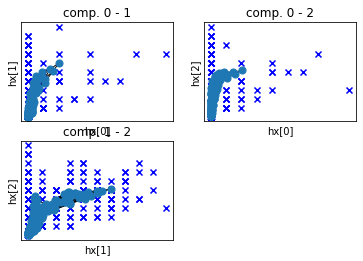

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1042  tErr : 0.7486
Epoch : 1 qErr : 0.0988  tErr : 0.7775
Epoch : 2 qErr : 0.0938  tErr : 0.7832
Epoch : 3 qErr : 0.0884  tErr : 0.7775
Epoch : 4 qErr : 0.0816  tErr : 0.7832
Epoch : 5 qErr : 0.0756  tErr : 0.8006
Epoch : 6 qErr : 0.0716  tErr : 0.8064
Epoch : 7 qErr : 0.0699  tErr : 0.8064
Epoch : 8 qErr : 0.0698  tErr : 0.8064
Epoch : 9 qErr : 0.0698  tErr : 0.8064


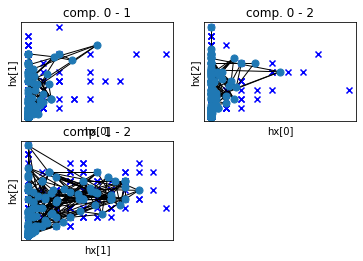

2it [00:24, 12.54s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1379  tErr : 0.7803
Epoch : 2 qErr : 0.1354  tErr : 0.7832
Epoch : 3 qErr : 0.1333  tErr : 0.7890
Epoch : 4 qErr : 0.1315  tErr : 0.7919
Epoch : 5 qErr : 0.1298  tErr : 0.7746
Epoch : 6 qErr : 0.1281  tErr : 0.7775
Epoch : 7 qErr : 0.1260  tErr : 0.7746
Epoch : 8 qErr : 0.1237  tErr : 0.7717
Epoch : 9 qErr : 0.1216  tErr : 0.7775


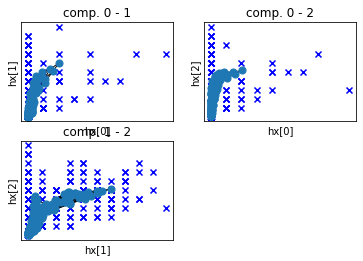

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1175  tErr : 0.7630
Epoch : 1 qErr : 0.1140  tErr : 0.7717
Epoch : 2 qErr : 0.1099  tErr : 0.7803
Epoch : 3 qErr : 0.1055  tErr : 0.7717
Epoch : 4 qErr : 0.0997  tErr : 0.7775
Epoch : 5 qErr : 0.0921  tErr : 0.7688
Epoch : 6 qErr : 0.0825  tErr : 0.7977
Epoch : 7 qErr : 0.0740  tErr : 0.8237
Epoch : 8 qErr : 0.0720  tErr : 0.8324
Epoch : 9 qErr : 0.0710  tErr : 0.8382


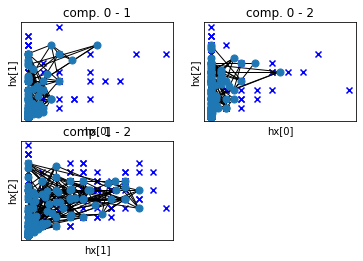

3it [00:34, 11.98s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1379  tErr : 0.7803
Epoch : 2 qErr : 0.1354  tErr : 0.7832
Epoch : 3 qErr : 0.1333  tErr : 0.7890
Epoch : 4 qErr : 0.1315  tErr : 0.7919
Epoch : 5 qErr : 0.1298  tErr : 0.7746
Epoch : 6 qErr : 0.1281  tErr : 0.7775
Epoch : 7 qErr : 0.1260  tErr : 0.7746
Epoch : 8 qErr : 0.1237  tErr : 0.7717
Epoch : 9 qErr : 0.1216  tErr : 0.7775


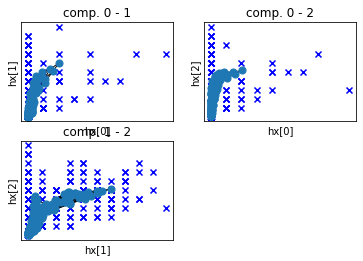

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1272  tErr : 0.7803
Epoch : 1 qErr : 0.1236  tErr : 0.7746
Epoch : 2 qErr : 0.1196  tErr : 0.7746
Epoch : 3 qErr : 0.1152  tErr : 0.7688
Epoch : 4 qErr : 0.1100  tErr : 0.7688
Epoch : 5 qErr : 0.1037  tErr : 0.7630
Epoch : 6 qErr : 0.0949  tErr : 0.7746
Epoch : 7 qErr : 0.0813  tErr : 0.7948
Epoch : 8 qErr : 0.0727  tErr : 0.8092
Epoch : 9 qErr : 0.0719  tErr : 0.8035


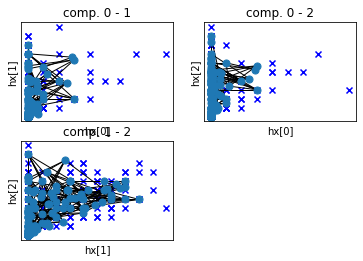

4it [00:45, 11.59s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1379  tErr : 0.7803
Epoch : 2 qErr : 0.1354  tErr : 0.7832
Epoch : 3 qErr : 0.1333  tErr : 0.7890
Epoch : 4 qErr : 0.1315  tErr : 0.7919
Epoch : 5 qErr : 0.1298  tErr : 0.7746
Epoch : 6 qErr : 0.1281  tErr : 0.7775
Epoch : 7 qErr : 0.1260  tErr : 0.7746
Epoch : 8 qErr : 0.1237  tErr : 0.7717
Epoch : 9 qErr : 0.1216  tErr : 0.7775


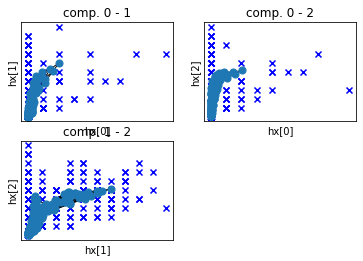

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1345  tErr : 0.7832
Epoch : 1 qErr : 0.1308  tErr : 0.7803
Epoch : 2 qErr : 0.1269  tErr : 0.7890
Epoch : 3 qErr : 0.1224  tErr : 0.7861
Epoch : 4 qErr : 0.1171  tErr : 0.7775
Epoch : 5 qErr : 0.1105  tErr : 0.7775
Epoch : 6 qErr : 0.1018  tErr : 0.7717
Epoch : 7 qErr : 0.0878  tErr : 0.7803
Epoch : 8 qErr : 0.0728  tErr : 0.7832
Epoch : 9 qErr : 0.0707  tErr : 0.7861


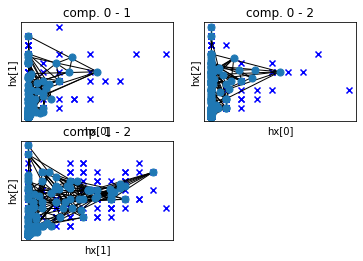

5it [00:55, 11.25s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1379  tErr : 0.7803
Epoch : 2 qErr : 0.1354  tErr : 0.7832
Epoch : 3 qErr : 0.1333  tErr : 0.7890
Epoch : 4 qErr : 0.1315  tErr : 0.7919
Epoch : 5 qErr : 0.1298  tErr : 0.7746
Epoch : 6 qErr : 0.1281  tErr : 0.7775
Epoch : 7 qErr : 0.1260  tErr : 0.7746
Epoch : 8 qErr : 0.1237  tErr : 0.7717
Epoch : 9 qErr : 0.1216  tErr : 0.7775


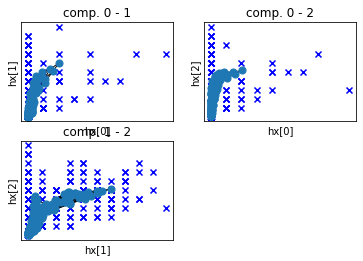

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1402  tErr : 0.7514
Epoch : 1 qErr : 0.1365  tErr : 0.7659
Epoch : 2 qErr : 0.1327  tErr : 0.7832
Epoch : 3 qErr : 0.1287  tErr : 0.7948
Epoch : 4 qErr : 0.1235  tErr : 0.7919
Epoch : 5 qErr : 0.1172  tErr : 0.7803
Epoch : 6 qErr : 0.1086  tErr : 0.7572
Epoch : 7 qErr : 0.0962  tErr : 0.7543
Epoch : 8 qErr : 0.0765  tErr : 0.7977
Epoch : 9 qErr : 0.0722  tErr : 0.8064


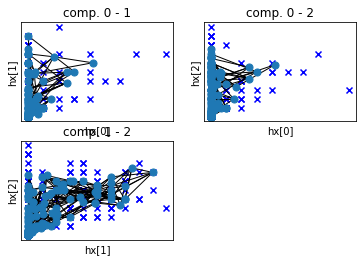

6it [01:06, 10.98s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1379  tErr : 0.7803
Epoch : 2 qErr : 0.1354  tErr : 0.7832
Epoch : 3 qErr : 0.1333  tErr : 0.7890
Epoch : 4 qErr : 0.1315  tErr : 0.7919
Epoch : 5 qErr : 0.1298  tErr : 0.7746
Epoch : 6 qErr : 0.1281  tErr : 0.7775
Epoch : 7 qErr : 0.1260  tErr : 0.7746
Epoch : 8 qErr : 0.1237  tErr : 0.7717
Epoch : 9 qErr : 0.1216  tErr : 0.7775


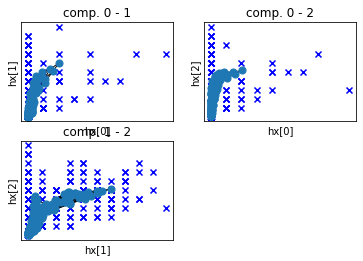

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1445  tErr : 0.7486
Epoch : 1 qErr : 0.1406  tErr : 0.7428
Epoch : 2 qErr : 0.1372  tErr : 0.7630
Epoch : 3 qErr : 0.1335  tErr : 0.7832
Epoch : 4 qErr : 0.1291  tErr : 0.7659
Epoch : 5 qErr : 0.1228  tErr : 0.7717
Epoch : 6 qErr : 0.1146  tErr : 0.7659
Epoch : 7 qErr : 0.1024  tErr : 0.7399
Epoch : 8 qErr : 0.0792  tErr : 0.7919
Epoch : 9 qErr : 0.0701  tErr : 0.8064


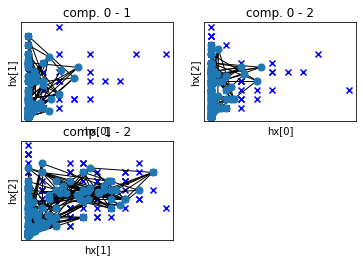

7it [01:16, 10.79s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1455  tErr : 0.7428
Epoch : 2 qErr : 0.1435  tErr : 0.7543
Epoch : 3 qErr : 0.1411  tErr : 0.7514
Epoch : 4 qErr : 0.1388  tErr : 0.7514
Epoch : 5 qErr : 0.1363  tErr : 0.7543
Epoch : 6 qErr : 0.1337  tErr : 0.7543
Epoch : 7 qErr : 0.1308  tErr : 0.7514
Epoch : 8 qErr : 0.1277  tErr : 0.7601
Epoch : 9 qErr : 0.1234  tErr : 0.7630


Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0827  tErr : 0.8121
Epoch : 1 qErr : 0.0728  tErr : 0.8208
Epoch : 2 qErr : 0.0697  tErr : 0.8150
Epoch : 3 qErr : 0.0691  tErr : 0.8150
Epoch : 4 qErr : 0.0691  tErr : 0.8150
Epoch : 5 qErr : 0.0691  tErr : 0.8150
Epoch : 6 qErr : 0.0691  tErr : 0.8150
Epoch : 7 qErr : 0.0691  tErr : 0.8150
Epoch : 8 qErr : 0.0691  tErr : 0.8150
Epoch : 9 qErr : 0.0691  tErr : 0.8150


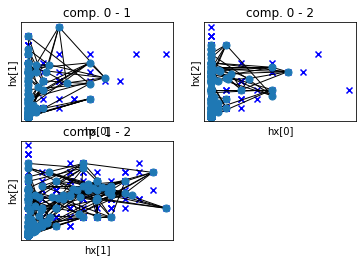

8it [01:27, 10.74s/it]

new best score 0.7096774193548387
new best config {'epochs': 10, 't_pahse1': 3, 't_phase2': 0, 't_pahse2': 0.3}
Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1455  tErr : 0.7428
Epoch : 2 qErr : 0.1435  tErr : 0.7543
Epoch : 3 qErr : 0.1411  tErr : 0.7514
Epoch : 4 qErr : 0.1388  tErr : 0.7514
Epoch : 5 qErr : 0.1363  tErr : 0.7543
Epoch : 6 qErr : 0.1337  tErr : 0.7543
Epoch : 7 qErr : 0.1308  tErr : 0.7514
Epoch : 8 qErr : 0.1277  tErr : 0.7601
Epoch : 9 qErr : 0.1234  tErr : 0.7630


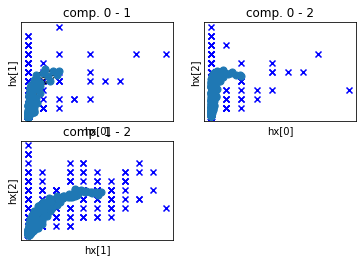

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1067  tErr : 0.7659
Epoch : 1 qErr : 0.1002  tErr : 0.7717
Epoch : 2 qErr : 0.0944  tErr : 0.7775
Epoch : 3 qErr : 0.0883  tErr : 0.7775
Epoch : 4 qErr : 0.0822  tErr : 0.7832
Epoch : 5 qErr : 0.0761  tErr : 0.8092
Epoch : 6 qErr : 0.0720  tErr : 0.8064
Epoch : 7 qErr : 0.0707  tErr : 0.8064
Epoch : 8 qErr : 0.0707  tErr : 0.8064
Epoch : 9 qErr : 0.0707  tErr : 0.8064


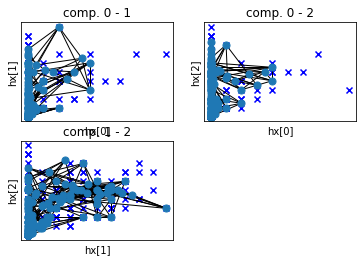

9it [01:37, 10.62s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1455  tErr : 0.7428
Epoch : 2 qErr : 0.1435  tErr : 0.7543
Epoch : 3 qErr : 0.1411  tErr : 0.7514
Epoch : 4 qErr : 0.1388  tErr : 0.7514
Epoch : 5 qErr : 0.1363  tErr : 0.7543
Epoch : 6 qErr : 0.1337  tErr : 0.7543
Epoch : 7 qErr : 0.1308  tErr : 0.7514
Epoch : 8 qErr : 0.1277  tErr : 0.7601
Epoch : 9 qErr : 0.1234  tErr : 0.7630


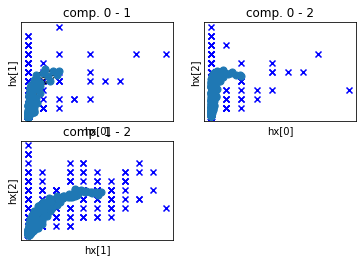

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1195  tErr : 0.7775
Epoch : 1 qErr : 0.1156  tErr : 0.7659
Epoch : 2 qErr : 0.1110  tErr : 0.7746
Epoch : 3 qErr : 0.1054  tErr : 0.7746
Epoch : 4 qErr : 0.0991  tErr : 0.7832
Epoch : 5 qErr : 0.0915  tErr : 0.7832
Epoch : 6 qErr : 0.0818  tErr : 0.7919
Epoch : 7 qErr : 0.0726  tErr : 0.8208
Epoch : 8 qErr : 0.0704  tErr : 0.8266
Epoch : 9 qErr : 0.0704  tErr : 0.8266


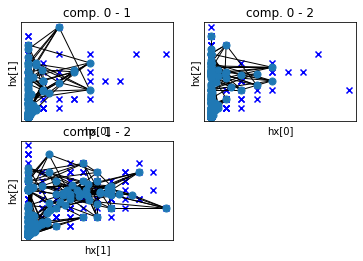

10it [01:48, 10.56s/it]

new best score 0.7258064516129032
new best config {'epochs': 10, 't_pahse1': 3, 't_phase2': 0, 't_pahse2': 1.0999999999999999}
Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1455  tErr : 0.7428
Epoch : 2 qErr : 0.1435  tErr : 0.7543
Epoch : 3 qErr : 0.1411  tErr : 0.7514
Epoch : 4 qErr : 0.1388  tErr : 0.7514
Epoch : 5 qErr : 0.1363  tErr : 0.7543
Epoch : 6 qErr : 0.1337  tErr : 0.7543
Epoch : 7 qErr : 0.1308  tErr : 0.7514
Epoch : 8 qErr : 0.1277  tErr : 0.7601
Epoch : 9 qErr : 0.1234  tErr : 0.7630


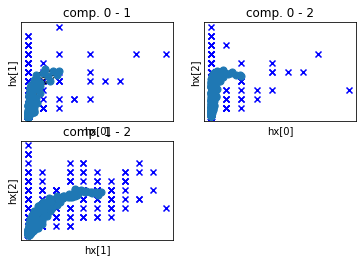

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1280  tErr : 0.7572
Epoch : 1 qErr : 0.1248  tErr : 0.7688
Epoch : 2 qErr : 0.1212  tErr : 0.7746
Epoch : 3 qErr : 0.1169  tErr : 0.7775
Epoch : 4 qErr : 0.1111  tErr : 0.7803
Epoch : 5 qErr : 0.1037  tErr : 0.7919
Epoch : 6 qErr : 0.0943  tErr : 0.7919
Epoch : 7 qErr : 0.0801  tErr : 0.8006
Epoch : 8 qErr : 0.0703  tErr : 0.8382
Epoch : 9 qErr : 0.0693  tErr : 0.8382


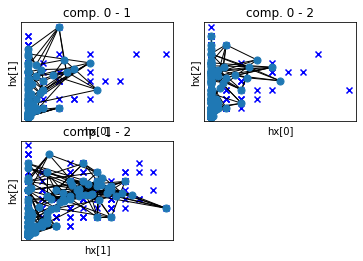

11it [01:58, 10.54s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1455  tErr : 0.7428
Epoch : 2 qErr : 0.1435  tErr : 0.7543
Epoch : 3 qErr : 0.1411  tErr : 0.7514
Epoch : 4 qErr : 0.1388  tErr : 0.7514
Epoch : 5 qErr : 0.1363  tErr : 0.7543
Epoch : 6 qErr : 0.1337  tErr : 0.7543
Epoch : 7 qErr : 0.1308  tErr : 0.7514
Epoch : 8 qErr : 0.1277  tErr : 0.7601
Epoch : 9 qErr : 0.1234  tErr : 0.7630


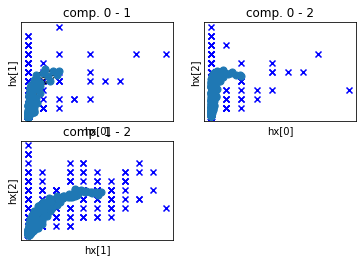

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1345  tErr : 0.7601
Epoch : 1 qErr : 0.1312  tErr : 0.7630
Epoch : 2 qErr : 0.1278  tErr : 0.7630
Epoch : 3 qErr : 0.1239  tErr : 0.7688
Epoch : 4 qErr : 0.1192  tErr : 0.7717
Epoch : 5 qErr : 0.1124  tErr : 0.7601
Epoch : 6 qErr : 0.1030  tErr : 0.7601
Epoch : 7 qErr : 0.0895  tErr : 0.7948
Epoch : 8 qErr : 0.0717  tErr : 0.8382
Epoch : 9 qErr : 0.0694  tErr : 0.8439


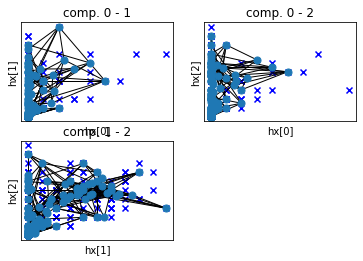

12it [02:08, 10.51s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1455  tErr : 0.7428
Epoch : 2 qErr : 0.1435  tErr : 0.7543
Epoch : 3 qErr : 0.1411  tErr : 0.7514
Epoch : 4 qErr : 0.1388  tErr : 0.7514
Epoch : 5 qErr : 0.1363  tErr : 0.7543
Epoch : 6 qErr : 0.1337  tErr : 0.7543
Epoch : 7 qErr : 0.1308  tErr : 0.7514
Epoch : 8 qErr : 0.1277  tErr : 0.7601
Epoch : 9 qErr : 0.1234  tErr : 0.7630


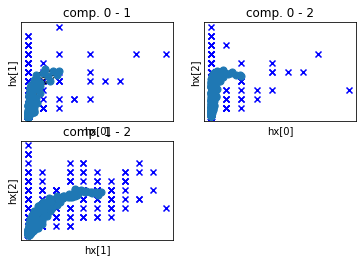

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1395  tErr : 0.7543
Epoch : 1 qErr : 0.1360  tErr : 0.7688
Epoch : 2 qErr : 0.1327  tErr : 0.7601
Epoch : 3 qErr : 0.1291  tErr : 0.7543
Epoch : 4 qErr : 0.1246  tErr : 0.7630
Epoch : 5 qErr : 0.1184  tErr : 0.7775
Epoch : 6 qErr : 0.1097  tErr : 0.7659
Epoch : 7 qErr : 0.0963  tErr : 0.7861
Epoch : 8 qErr : 0.0765  tErr : 0.8382
Epoch : 9 qErr : 0.0716  tErr : 0.8353


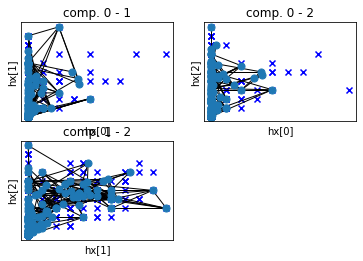

13it [02:19, 10.55s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1455  tErr : 0.7428
Epoch : 2 qErr : 0.1435  tErr : 0.7543
Epoch : 3 qErr : 0.1411  tErr : 0.7514
Epoch : 4 qErr : 0.1388  tErr : 0.7514
Epoch : 5 qErr : 0.1363  tErr : 0.7543
Epoch : 6 qErr : 0.1337  tErr : 0.7543
Epoch : 7 qErr : 0.1308  tErr : 0.7514
Epoch : 8 qErr : 0.1277  tErr : 0.7601
Epoch : 9 qErr : 0.1234  tErr : 0.7630


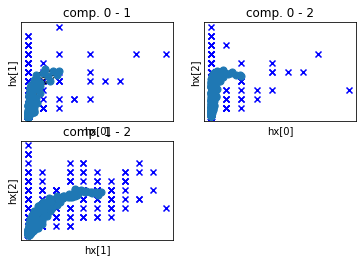

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1439  tErr : 0.7457
Epoch : 1 qErr : 0.1402  tErr : 0.7543
Epoch : 2 qErr : 0.1367  tErr : 0.7572
Epoch : 3 qErr : 0.1329  tErr : 0.7630
Epoch : 4 qErr : 0.1287  tErr : 0.7659
Epoch : 5 qErr : 0.1239  tErr : 0.7688
Epoch : 6 qErr : 0.1160  tErr : 0.7775
Epoch : 7 qErr : 0.1035  tErr : 0.7832
Epoch : 8 qErr : 0.0807  tErr : 0.7861
Epoch : 9 qErr : 0.0713  tErr : 0.8064


14it [02:30, 10.52s/it]

new best score 0.7419354838709677
new best config {'epochs': 10, 't_pahse1': 3, 't_phase2': 0, 't_pahse2': 2.6999999999999997}
Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1528  tErr : 0.7081
Epoch : 1 qErr : 0.1511  tErr : 0.7168
Epoch : 2 qErr : 0.1490  tErr : 0.7312
Epoch : 3 qErr : 0.1469  tErr : 0.7254
Epoch : 4 qErr : 0.1443  tErr : 0.7370
Epoch : 5 qErr : 0.1414  tErr : 0.7486
Epoch : 6 qErr : 0.1379  tErr : 0.7486
Epoch : 7 qErr : 0.1340  tErr : 0.7514
Epoch : 8 qErr : 0.1295  tErr : 0.7601
Epoch : 9 qErr : 0.1244  tErr : 0.7572


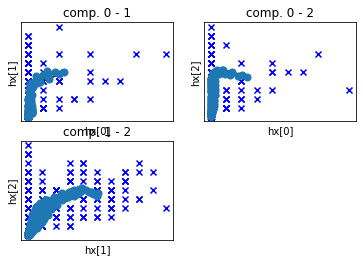

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0838  tErr : 0.8208
Epoch : 1 qErr : 0.0726  tErr : 0.8150
Epoch : 2 qErr : 0.0696  tErr : 0.8237
Epoch : 3 qErr : 0.0686  tErr : 0.8208
Epoch : 4 qErr : 0.0683  tErr : 0.8295
Epoch : 5 qErr : 0.0683  tErr : 0.8295
Epoch : 6 qErr : 0.0683  tErr : 0.8295
Epoch : 7 qErr : 0.0683  tErr : 0.8295
Epoch : 8 qErr : 0.0683  tErr : 0.8295
Epoch : 9 qErr : 0.0683  tErr : 0.8266


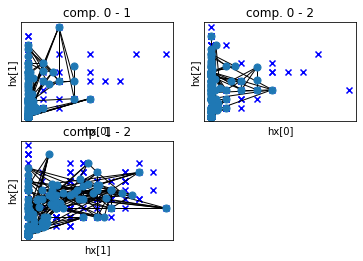

15it [02:40, 10.47s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1528  tErr : 0.7081
Epoch : 1 qErr : 0.1511  tErr : 0.7168
Epoch : 2 qErr : 0.1490  tErr : 0.7312
Epoch : 3 qErr : 0.1469  tErr : 0.7254
Epoch : 4 qErr : 0.1443  tErr : 0.7370
Epoch : 5 qErr : 0.1414  tErr : 0.7486
Epoch : 6 qErr : 0.1379  tErr : 0.7486
Epoch : 7 qErr : 0.1340  tErr : 0.7514
Epoch : 8 qErr : 0.1295  tErr : 0.7601
Epoch : 9 qErr : 0.1244  tErr : 0.7572


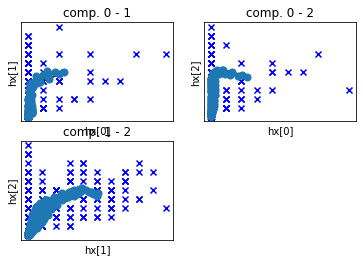

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1077  tErr : 0.7775
Epoch : 1 qErr : 0.1010  tErr : 0.7832
Epoch : 2 qErr : 0.0945  tErr : 0.7977
Epoch : 3 qErr : 0.0884  tErr : 0.8006
Epoch : 4 qErr : 0.0814  tErr : 0.8150
Epoch : 5 qErr : 0.0750  tErr : 0.8208
Epoch : 6 qErr : 0.0709  tErr : 0.8324
Epoch : 7 qErr : 0.0698  tErr : 0.8382
Epoch : 8 qErr : 0.0698  tErr : 0.8382
Epoch : 9 qErr : 0.0698  tErr : 0.8410


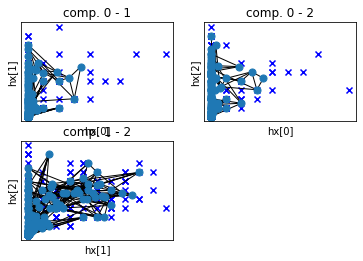

16it [02:50, 10.44s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1528  tErr : 0.7081
Epoch : 1 qErr : 0.1511  tErr : 0.7168
Epoch : 2 qErr : 0.1490  tErr : 0.7312
Epoch : 3 qErr : 0.1469  tErr : 0.7254
Epoch : 4 qErr : 0.1443  tErr : 0.7370
Epoch : 5 qErr : 0.1414  tErr : 0.7486
Epoch : 6 qErr : 0.1379  tErr : 0.7486
Epoch : 7 qErr : 0.1340  tErr : 0.7514
Epoch : 8 qErr : 0.1295  tErr : 0.7601
Epoch : 9 qErr : 0.1244  tErr : 0.7572


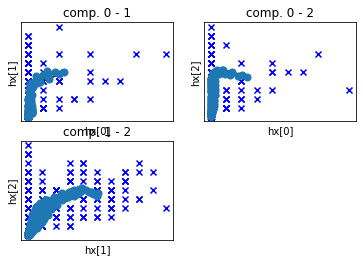

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1197  tErr : 0.7601
Epoch : 1 qErr : 0.1160  tErr : 0.7717
Epoch : 2 qErr : 0.1121  tErr : 0.7717
Epoch : 3 qErr : 0.1074  tErr : 0.7688
Epoch : 4 qErr : 0.1013  tErr : 0.7919
Epoch : 5 qErr : 0.0933  tErr : 0.8150
Epoch : 6 qErr : 0.0832  tErr : 0.8266
Epoch : 7 qErr : 0.0740  tErr : 0.8353
Epoch : 8 qErr : 0.0711  tErr : 0.8497
Epoch : 9 qErr : 0.0709  tErr : 0.8497


17it [03:01, 10.44s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1528  tErr : 0.7081
Epoch : 1 qErr : 0.1511  tErr : 0.7168
Epoch : 2 qErr : 0.1490  tErr : 0.7312
Epoch : 3 qErr : 0.1469  tErr : 0.7254
Epoch : 4 qErr : 0.1443  tErr : 0.7370
Epoch : 5 qErr : 0.1414  tErr : 0.7486
Epoch : 6 qErr : 0.1379  tErr : 0.7486
Epoch : 7 qErr : 0.1340  tErr : 0.7514
Epoch : 8 qErr : 0.1295  tErr : 0.7601
Epoch : 9 qErr : 0.1244  tErr : 0.7572


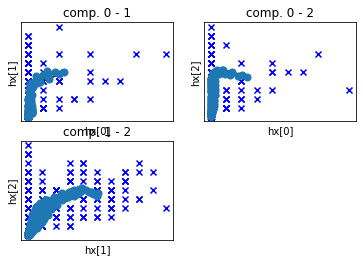

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1278  tErr : 0.7630
Epoch : 1 qErr : 0.1249  tErr : 0.7601
Epoch : 2 qErr : 0.1211  tErr : 0.7803
Epoch : 3 qErr : 0.1167  tErr : 0.7803
Epoch : 4 qErr : 0.1115  tErr : 0.7746
Epoch : 5 qErr : 0.1046  tErr : 0.7775
Epoch : 6 qErr : 0.0954  tErr : 0.7861
Epoch : 7 qErr : 0.0827  tErr : 0.8237
Epoch : 8 qErr : 0.0726  tErr : 0.8150
Epoch : 9 qErr : 0.0712  tErr : 0.8121


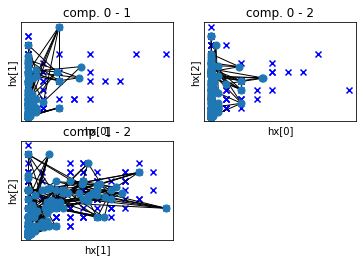

18it [03:11, 10.41s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1528  tErr : 0.7081
Epoch : 1 qErr : 0.1511  tErr : 0.7168
Epoch : 2 qErr : 0.1490  tErr : 0.7312
Epoch : 3 qErr : 0.1469  tErr : 0.7254
Epoch : 4 qErr : 0.1443  tErr : 0.7370
Epoch : 5 qErr : 0.1414  tErr : 0.7486
Epoch : 6 qErr : 0.1379  tErr : 0.7486
Epoch : 7 qErr : 0.1340  tErr : 0.7514
Epoch : 8 qErr : 0.1295  tErr : 0.7601
Epoch : 9 qErr : 0.1244  tErr : 0.7572


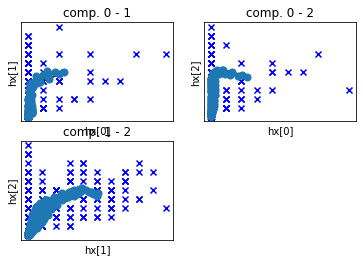

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1342  tErr : 0.7630
Epoch : 1 qErr : 0.1311  tErr : 0.7601
Epoch : 2 qErr : 0.1278  tErr : 0.7630
Epoch : 3 qErr : 0.1239  tErr : 0.7746
Epoch : 4 qErr : 0.1190  tErr : 0.7775
Epoch : 5 qErr : 0.1125  tErr : 0.7746
Epoch : 6 qErr : 0.1036  tErr : 0.7775
Epoch : 7 qErr : 0.0911  tErr : 0.7775
Epoch : 8 qErr : 0.0753  tErr : 0.8150
Epoch : 9 qErr : 0.0723  tErr : 0.8150


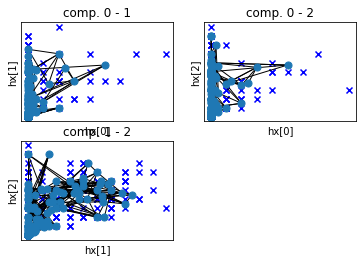

19it [03:21, 10.40s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1528  tErr : 0.7081
Epoch : 1 qErr : 0.1511  tErr : 0.7168
Epoch : 2 qErr : 0.1490  tErr : 0.7312
Epoch : 3 qErr : 0.1469  tErr : 0.7254
Epoch : 4 qErr : 0.1443  tErr : 0.7370
Epoch : 5 qErr : 0.1414  tErr : 0.7486
Epoch : 6 qErr : 0.1379  tErr : 0.7486
Epoch : 7 qErr : 0.1340  tErr : 0.7514
Epoch : 8 qErr : 0.1295  tErr : 0.7601
Epoch : 9 qErr : 0.1244  tErr : 0.7572


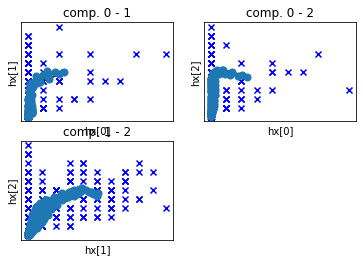

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1392  tErr : 0.7514
Epoch : 1 qErr : 0.1357  tErr : 0.7601
Epoch : 2 qErr : 0.1325  tErr : 0.7861
Epoch : 3 qErr : 0.1290  tErr : 0.7832
Epoch : 4 qErr : 0.1243  tErr : 0.7775
Epoch : 5 qErr : 0.1185  tErr : 0.7832
Epoch : 6 qErr : 0.1097  tErr : 0.7890
Epoch : 7 qErr : 0.0961  tErr : 0.8150
Epoch : 8 qErr : 0.0745  tErr : 0.8179
Epoch : 9 qErr : 0.0690  tErr : 0.8295


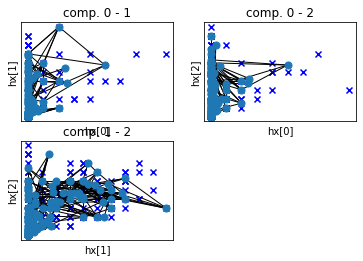

20it [03:32, 10.47s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1528  tErr : 0.7081
Epoch : 1 qErr : 0.1511  tErr : 0.7168
Epoch : 2 qErr : 0.1490  tErr : 0.7312
Epoch : 3 qErr : 0.1469  tErr : 0.7254
Epoch : 4 qErr : 0.1443  tErr : 0.7370
Epoch : 5 qErr : 0.1414  tErr : 0.7486
Epoch : 6 qErr : 0.1379  tErr : 0.7486
Epoch : 7 qErr : 0.1340  tErr : 0.7514
Epoch : 8 qErr : 0.1295  tErr : 0.7601
Epoch : 9 qErr : 0.1244  tErr : 0.7572


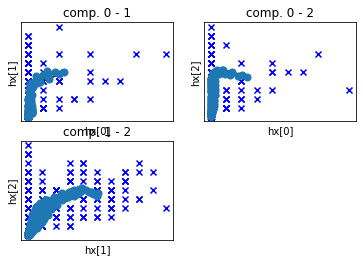

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1434  tErr : 0.7457
Epoch : 1 qErr : 0.1401  tErr : 0.7486
Epoch : 2 qErr : 0.1367  tErr : 0.7543
Epoch : 3 qErr : 0.1329  tErr : 0.7717
Epoch : 4 qErr : 0.1289  tErr : 0.7746
Epoch : 5 qErr : 0.1237  tErr : 0.7688
Epoch : 6 qErr : 0.1155  tErr : 0.7861
Epoch : 7 qErr : 0.1034  tErr : 0.7890
Epoch : 8 qErr : 0.0824  tErr : 0.7948
Epoch : 9 qErr : 0.0738  tErr : 0.8035


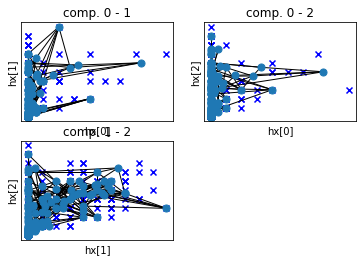

21it [03:42, 10.43s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1575  tErr : 0.6879
Epoch : 1 qErr : 0.1552  tErr : 0.6936
Epoch : 2 qErr : 0.1531  tErr : 0.6936
Epoch : 3 qErr : 0.1509  tErr : 0.7139
Epoch : 4 qErr : 0.1485  tErr : 0.7370
Epoch : 5 qErr : 0.1455  tErr : 0.7370
Epoch : 6 qErr : 0.1416  tErr : 0.7457
Epoch : 7 qErr : 0.1371  tErr : 0.7370
Epoch : 8 qErr : 0.1318  tErr : 0.7457
Epoch : 9 qErr : 0.1252  tErr : 0.7543


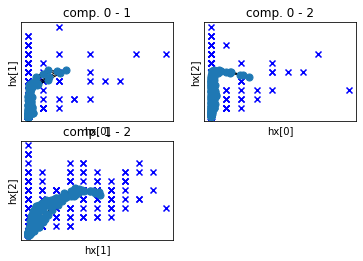

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0832  tErr : 0.8410
Epoch : 1 qErr : 0.0759  tErr : 0.8324
Epoch : 2 qErr : 0.0734  tErr : 0.8295
Epoch : 3 qErr : 0.0728  tErr : 0.8266
Epoch : 4 qErr : 0.0728  tErr : 0.8266
Epoch : 5 qErr : 0.0728  tErr : 0.8266
Epoch : 6 qErr : 0.0728  tErr : 0.8266
Epoch : 7 qErr : 0.0728  tErr : 0.8266
Epoch : 8 qErr : 0.0728  tErr : 0.8266
Epoch : 9 qErr : 0.0728  tErr : 0.8266


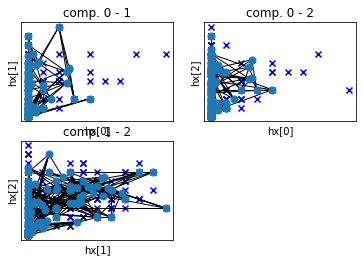

22it [03:53, 10.41s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1575  tErr : 0.6879
Epoch : 1 qErr : 0.1552  tErr : 0.6936
Epoch : 2 qErr : 0.1531  tErr : 0.6936
Epoch : 3 qErr : 0.1509  tErr : 0.7139
Epoch : 4 qErr : 0.1485  tErr : 0.7370
Epoch : 5 qErr : 0.1455  tErr : 0.7370
Epoch : 6 qErr : 0.1416  tErr : 0.7457
Epoch : 7 qErr : 0.1371  tErr : 0.7370
Epoch : 8 qErr : 0.1318  tErr : 0.7457
Epoch : 9 qErr : 0.1252  tErr : 0.7543


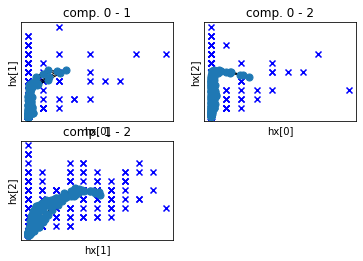

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1086  tErr : 0.7775
Epoch : 1 qErr : 0.1014  tErr : 0.7717
Epoch : 2 qErr : 0.0960  tErr : 0.7803
Epoch : 3 qErr : 0.0902  tErr : 0.7890
Epoch : 4 qErr : 0.0835  tErr : 0.7861
Epoch : 5 qErr : 0.0772  tErr : 0.7948
Epoch : 6 qErr : 0.0729  tErr : 0.8035
Epoch : 7 qErr : 0.0719  tErr : 0.8035
Epoch : 8 qErr : 0.0718  tErr : 0.8035
Epoch : 9 qErr : 0.0717  tErr : 0.8064


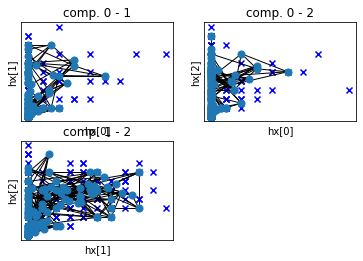

23it [04:03, 10.43s/it]

new best score 0.7580645161290323
new best config {'epochs': 10, 't_pahse1': 5, 't_phase2': 0, 't_pahse2': 0.7}
Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1575  tErr : 0.6879
Epoch : 1 qErr : 0.1552  tErr : 0.6936
Epoch : 2 qErr : 0.1531  tErr : 0.6936
Epoch : 3 qErr : 0.1509  tErr : 0.7139
Epoch : 4 qErr : 0.1485  tErr : 0.7370
Epoch : 5 qErr : 0.1455  tErr : 0.7370
Epoch : 6 qErr : 0.1416  tErr : 0.7457
Epoch : 7 qErr : 0.1371  tErr : 0.7370
Epoch : 8 qErr : 0.1318  tErr : 0.7457
Epoch : 9 qErr : 0.1252  tErr : 0.7543


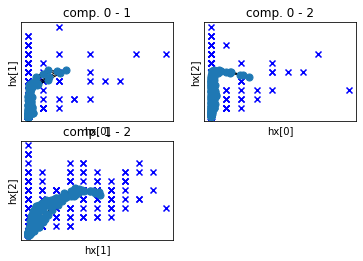

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1204  tErr : 0.7717
Epoch : 1 qErr : 0.1164  tErr : 0.7688
Epoch : 2 qErr : 0.1121  tErr : 0.7659
Epoch : 3 qErr : 0.1071  tErr : 0.7543
Epoch : 4 qErr : 0.1011  tErr : 0.7630
Epoch : 5 qErr : 0.0934  tErr : 0.7775
Epoch : 6 qErr : 0.0837  tErr : 0.8064
Epoch : 7 qErr : 0.0733  tErr : 0.8208
Epoch : 8 qErr : 0.0704  tErr : 0.8179
Epoch : 9 qErr : 0.0703  tErr : 0.8208


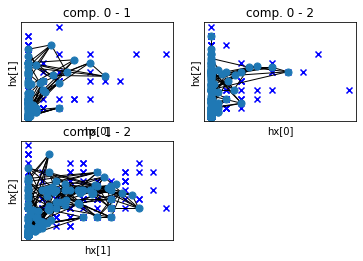

24it [04:14, 10.42s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1575  tErr : 0.6879
Epoch : 1 qErr : 0.1552  tErr : 0.6936
Epoch : 2 qErr : 0.1531  tErr : 0.6936
Epoch : 3 qErr : 0.1509  tErr : 0.7139
Epoch : 4 qErr : 0.1485  tErr : 0.7370
Epoch : 5 qErr : 0.1455  tErr : 0.7370
Epoch : 6 qErr : 0.1416  tErr : 0.7457
Epoch : 7 qErr : 0.1371  tErr : 0.7370
Epoch : 8 qErr : 0.1318  tErr : 0.7457
Epoch : 9 qErr : 0.1252  tErr : 0.7543


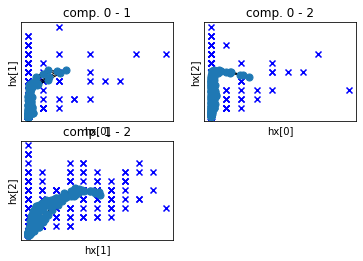

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1284  tErr : 0.7543
Epoch : 1 qErr : 0.1249  tErr : 0.7688
Epoch : 2 qErr : 0.1212  tErr : 0.7659
Epoch : 3 qErr : 0.1171  tErr : 0.7717
Epoch : 4 qErr : 0.1115  tErr : 0.7717
Epoch : 5 qErr : 0.1048  tErr : 0.7832
Epoch : 6 qErr : 0.0949  tErr : 0.7746
Epoch : 7 qErr : 0.0823  tErr : 0.8064
Epoch : 8 qErr : 0.0728  tErr : 0.8208
Epoch : 9 qErr : 0.0713  tErr : 0.8324


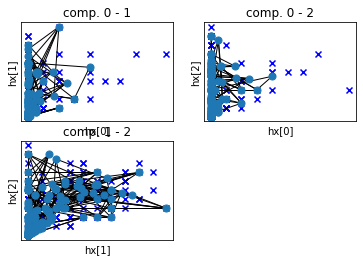

25it [04:24, 10.41s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1575  tErr : 0.6879
Epoch : 1 qErr : 0.1552  tErr : 0.6936
Epoch : 2 qErr : 0.1531  tErr : 0.6936
Epoch : 3 qErr : 0.1509  tErr : 0.7139
Epoch : 4 qErr : 0.1485  tErr : 0.7370
Epoch : 5 qErr : 0.1455  tErr : 0.7370
Epoch : 6 qErr : 0.1416  tErr : 0.7457
Epoch : 7 qErr : 0.1371  tErr : 0.7370
Epoch : 8 qErr : 0.1318  tErr : 0.7457
Epoch : 9 qErr : 0.1252  tErr : 0.7543


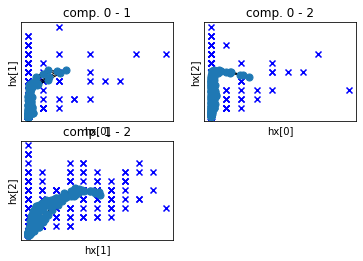

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1345  tErr : 0.7543
Epoch : 1 qErr : 0.1311  tErr : 0.7543
Epoch : 2 qErr : 0.1278  tErr : 0.7601
Epoch : 3 qErr : 0.1240  tErr : 0.7630
Epoch : 4 qErr : 0.1190  tErr : 0.7630
Epoch : 5 qErr : 0.1124  tErr : 0.7688
Epoch : 6 qErr : 0.1035  tErr : 0.7832
Epoch : 7 qErr : 0.0912  tErr : 0.7919
Epoch : 8 qErr : 0.0752  tErr : 0.8179
Epoch : 9 qErr : 0.0727  tErr : 0.8179


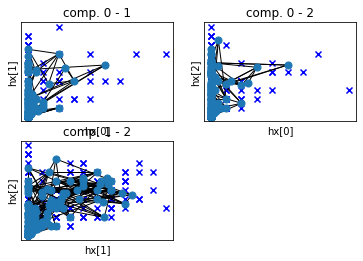

26it [04:35, 10.45s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1575  tErr : 0.6879
Epoch : 1 qErr : 0.1552  tErr : 0.6936
Epoch : 2 qErr : 0.1531  tErr : 0.6936
Epoch : 3 qErr : 0.1509  tErr : 0.7139
Epoch : 4 qErr : 0.1485  tErr : 0.7370
Epoch : 5 qErr : 0.1455  tErr : 0.7370
Epoch : 6 qErr : 0.1416  tErr : 0.7457
Epoch : 7 qErr : 0.1371  tErr : 0.7370
Epoch : 8 qErr : 0.1318  tErr : 0.7457
Epoch : 9 qErr : 0.1252  tErr : 0.7543


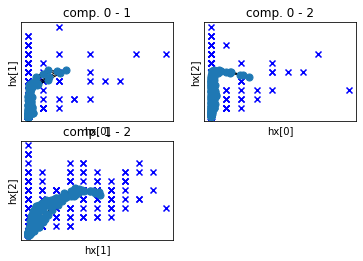

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1393  tErr : 0.7457
Epoch : 1 qErr : 0.1357  tErr : 0.7486
Epoch : 2 qErr : 0.1326  tErr : 0.7486
Epoch : 3 qErr : 0.1291  tErr : 0.7659
Epoch : 4 qErr : 0.1246  tErr : 0.7688
Epoch : 5 qErr : 0.1186  tErr : 0.7717
Epoch : 6 qErr : 0.1099  tErr : 0.7832
Epoch : 7 qErr : 0.0972  tErr : 0.8121
Epoch : 8 qErr : 0.0759  tErr : 0.8468
Epoch : 9 qErr : 0.0698  tErr : 0.8555


27it [04:45, 10.47s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1575  tErr : 0.6879
Epoch : 1 qErr : 0.1552  tErr : 0.6936
Epoch : 2 qErr : 0.1531  tErr : 0.6936
Epoch : 3 qErr : 0.1509  tErr : 0.7139
Epoch : 4 qErr : 0.1485  tErr : 0.7370
Epoch : 5 qErr : 0.1455  tErr : 0.7370
Epoch : 6 qErr : 0.1416  tErr : 0.7457
Epoch : 7 qErr : 0.1371  tErr : 0.7370
Epoch : 8 qErr : 0.1318  tErr : 0.7457
Epoch : 9 qErr : 0.1252  tErr : 0.7543


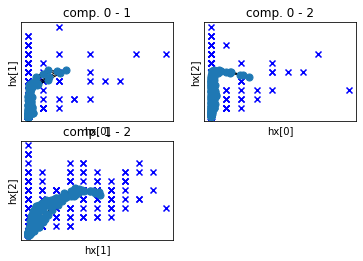

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1436  tErr : 0.7341
Epoch : 1 qErr : 0.1400  tErr : 0.7399
Epoch : 2 qErr : 0.1367  tErr : 0.7399
Epoch : 3 qErr : 0.1333  tErr : 0.7457
Epoch : 4 qErr : 0.1292  tErr : 0.7746
Epoch : 5 qErr : 0.1239  tErr : 0.7775
Epoch : 6 qErr : 0.1154  tErr : 0.7977
Epoch : 7 qErr : 0.1032  tErr : 0.8092
Epoch : 8 qErr : 0.0817  tErr : 0.8295
Epoch : 9 qErr : 0.0721  tErr : 0.8324


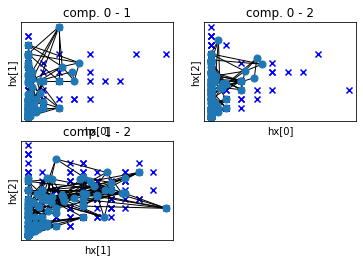

28it [04:55, 10.44s/it]

new best score 0.7741935483870968
new best config {'epochs': 10, 't_pahse1': 5, 't_phase2': 0, 't_pahse2': 2.6999999999999997}
Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1623  tErr : 0.6618
Epoch : 1 qErr : 0.1594  tErr : 0.6618
Epoch : 2 qErr : 0.1568  tErr : 0.6792
Epoch : 3 qErr : 0.1542  tErr : 0.6965
Epoch : 4 qErr : 0.1516  tErr : 0.7052
Epoch : 5 qErr : 0.1487  tErr : 0.7254
Epoch : 6 qErr : 0.1449  tErr : 0.7283
Epoch : 7 qErr : 0.1397  tErr : 0.7370
Epoch : 8 qErr : 0.1333  tErr : 0.7399
Epoch : 9 qErr : 0.1262  tErr : 0.7457


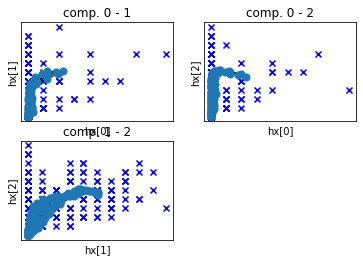

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0850  tErr : 0.8410
Epoch : 1 qErr : 0.0724  tErr : 0.8671
Epoch : 2 qErr : 0.0684  tErr : 0.8613
Epoch : 3 qErr : 0.0676  tErr : 0.8671
Epoch : 4 qErr : 0.0676  tErr : 0.8671
Epoch : 5 qErr : 0.0676  tErr : 0.8671
Epoch : 6 qErr : 0.0676  tErr : 0.8671
Epoch : 7 qErr : 0.0676  tErr : 0.8671
Epoch : 8 qErr : 0.0676  tErr : 0.8671
Epoch : 9 qErr : 0.0676  tErr : 0.8671


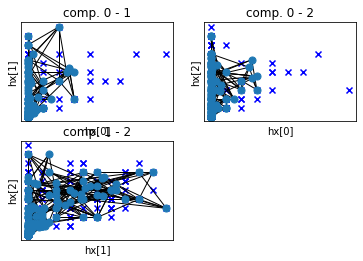

29it [05:06, 10.44s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1623  tErr : 0.6618
Epoch : 1 qErr : 0.1594  tErr : 0.6618
Epoch : 2 qErr : 0.1568  tErr : 0.6792
Epoch : 3 qErr : 0.1542  tErr : 0.6965
Epoch : 4 qErr : 0.1516  tErr : 0.7052
Epoch : 5 qErr : 0.1487  tErr : 0.7254
Epoch : 6 qErr : 0.1449  tErr : 0.7283
Epoch : 7 qErr : 0.1397  tErr : 0.7370
Epoch : 8 qErr : 0.1333  tErr : 0.7399
Epoch : 9 qErr : 0.1262  tErr : 0.7457


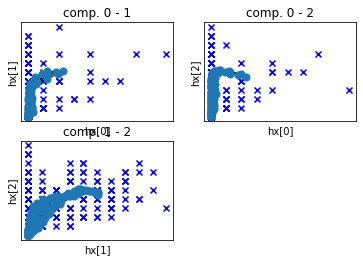

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1099  tErr : 0.7543
Epoch : 1 qErr : 0.1016  tErr : 0.7746
Epoch : 2 qErr : 0.0952  tErr : 0.7919
Epoch : 3 qErr : 0.0889  tErr : 0.7890
Epoch : 4 qErr : 0.0816  tErr : 0.7977
Epoch : 5 qErr : 0.0747  tErr : 0.8237
Epoch : 6 qErr : 0.0702  tErr : 0.8526
Epoch : 7 qErr : 0.0693  tErr : 0.8468
Epoch : 8 qErr : 0.0689  tErr : 0.8439
Epoch : 9 qErr : 0.0689  tErr : 0.8439


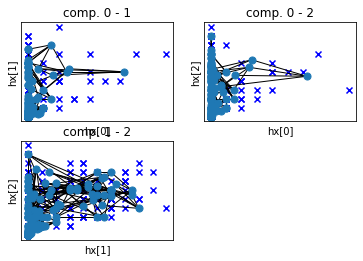

30it [05:17, 10.60s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1623  tErr : 0.6618
Epoch : 1 qErr : 0.1594  tErr : 0.6618
Epoch : 2 qErr : 0.1568  tErr : 0.6792
Epoch : 3 qErr : 0.1542  tErr : 0.6965
Epoch : 4 qErr : 0.1516  tErr : 0.7052
Epoch : 5 qErr : 0.1487  tErr : 0.7254
Epoch : 6 qErr : 0.1449  tErr : 0.7283
Epoch : 7 qErr : 0.1397  tErr : 0.7370
Epoch : 8 qErr : 0.1333  tErr : 0.7399
Epoch : 9 qErr : 0.1262  tErr : 0.7457


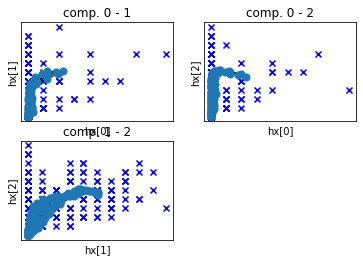

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1212  tErr : 0.7543
Epoch : 1 qErr : 0.1168  tErr : 0.7775
Epoch : 2 qErr : 0.1125  tErr : 0.7717
Epoch : 3 qErr : 0.1073  tErr : 0.7717
Epoch : 4 qErr : 0.1009  tErr : 0.7775
Epoch : 5 qErr : 0.0927  tErr : 0.7803
Epoch : 6 qErr : 0.0822  tErr : 0.8179
Epoch : 7 qErr : 0.0735  tErr : 0.8295
Epoch : 8 qErr : 0.0708  tErr : 0.8295
Epoch : 9 qErr : 0.0703  tErr : 0.8150


31it [05:27, 10.56s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1623  tErr : 0.6618
Epoch : 1 qErr : 0.1594  tErr : 0.6618
Epoch : 2 qErr : 0.1568  tErr : 0.6792
Epoch : 3 qErr : 0.1542  tErr : 0.6965
Epoch : 4 qErr : 0.1516  tErr : 0.7052
Epoch : 5 qErr : 0.1487  tErr : 0.7254
Epoch : 6 qErr : 0.1449  tErr : 0.7283
Epoch : 7 qErr : 0.1397  tErr : 0.7370
Epoch : 8 qErr : 0.1333  tErr : 0.7399
Epoch : 9 qErr : 0.1262  tErr : 0.7457


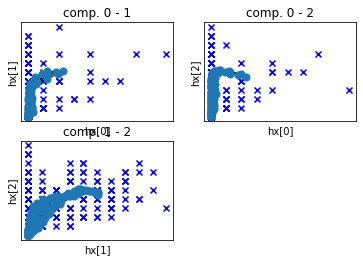

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1288  tErr : 0.7601
Epoch : 1 qErr : 0.1254  tErr : 0.7688
Epoch : 2 qErr : 0.1216  tErr : 0.7630
Epoch : 3 qErr : 0.1171  tErr : 0.7746
Epoch : 4 qErr : 0.1110  tErr : 0.7775
Epoch : 5 qErr : 0.1037  tErr : 0.7890
Epoch : 6 qErr : 0.0944  tErr : 0.7832
Epoch : 7 qErr : 0.0809  tErr : 0.8208
Epoch : 8 qErr : 0.0726  tErr : 0.8179
Epoch : 9 qErr : 0.0699  tErr : 0.8295


32it [05:38, 10.62s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1623  tErr : 0.6618
Epoch : 1 qErr : 0.1594  tErr : 0.6618
Epoch : 2 qErr : 0.1568  tErr : 0.6792
Epoch : 3 qErr : 0.1542  tErr : 0.6965
Epoch : 4 qErr : 0.1516  tErr : 0.7052
Epoch : 5 qErr : 0.1487  tErr : 0.7254
Epoch : 6 qErr : 0.1449  tErr : 0.7283
Epoch : 7 qErr : 0.1397  tErr : 0.7370
Epoch : 8 qErr : 0.1333  tErr : 0.7399
Epoch : 9 qErr : 0.1262  tErr : 0.7457


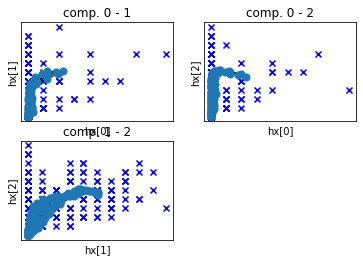

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1346  tErr : 0.7572
Epoch : 1 qErr : 0.1313  tErr : 0.7572
Epoch : 2 qErr : 0.1280  tErr : 0.7688
Epoch : 3 qErr : 0.1243  tErr : 0.7688
Epoch : 4 qErr : 0.1187  tErr : 0.7659
Epoch : 5 qErr : 0.1119  tErr : 0.7630
Epoch : 6 qErr : 0.1025  tErr : 0.7803
Epoch : 7 qErr : 0.0886  tErr : 0.8006
Epoch : 8 qErr : 0.0731  tErr : 0.8324
Epoch : 9 qErr : 0.0690  tErr : 0.8237


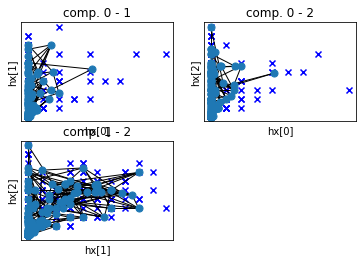

33it [05:48, 10.54s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1623  tErr : 0.6618
Epoch : 1 qErr : 0.1594  tErr : 0.6618
Epoch : 2 qErr : 0.1568  tErr : 0.6792
Epoch : 3 qErr : 0.1542  tErr : 0.6965
Epoch : 4 qErr : 0.1516  tErr : 0.7052
Epoch : 5 qErr : 0.1487  tErr : 0.7254
Epoch : 6 qErr : 0.1449  tErr : 0.7283
Epoch : 7 qErr : 0.1397  tErr : 0.7370
Epoch : 8 qErr : 0.1333  tErr : 0.7399
Epoch : 9 qErr : 0.1262  tErr : 0.7457


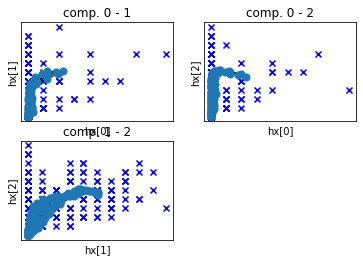

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1393  tErr : 0.7630
Epoch : 1 qErr : 0.1358  tErr : 0.7572
Epoch : 2 qErr : 0.1327  tErr : 0.7659
Epoch : 3 qErr : 0.1291  tErr : 0.7688
Epoch : 4 qErr : 0.1247  tErr : 0.7659
Epoch : 5 qErr : 0.1184  tErr : 0.7775
Epoch : 6 qErr : 0.1097  tErr : 0.7919
Epoch : 7 qErr : 0.0967  tErr : 0.8035
Epoch : 8 qErr : 0.0767  tErr : 0.8295
Epoch : 9 qErr : 0.0705  tErr : 0.8295


34it [05:59, 10.50s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1623  tErr : 0.6618
Epoch : 1 qErr : 0.1594  tErr : 0.6618
Epoch : 2 qErr : 0.1568  tErr : 0.6792
Epoch : 3 qErr : 0.1542  tErr : 0.6965
Epoch : 4 qErr : 0.1516  tErr : 0.7052
Epoch : 5 qErr : 0.1487  tErr : 0.7254
Epoch : 6 qErr : 0.1449  tErr : 0.7283
Epoch : 7 qErr : 0.1397  tErr : 0.7370
Epoch : 8 qErr : 0.1333  tErr : 0.7399
Epoch : 9 qErr : 0.1262  tErr : 0.7457


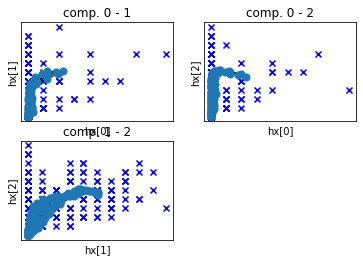

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1434  tErr : 0.7312
Epoch : 1 qErr : 0.1400  tErr : 0.7312
Epoch : 2 qErr : 0.1368  tErr : 0.7514
Epoch : 3 qErr : 0.1333  tErr : 0.7717
Epoch : 4 qErr : 0.1290  tErr : 0.7861
Epoch : 5 qErr : 0.1233  tErr : 0.7803
Epoch : 6 qErr : 0.1151  tErr : 0.7919
Epoch : 7 qErr : 0.1026  tErr : 0.7803
Epoch : 8 qErr : 0.0780  tErr : 0.8266
Epoch : 9 qErr : 0.0679  tErr : 0.8179


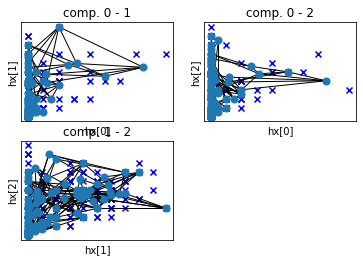

35it [06:09, 10.50s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1666  tErr : 0.6329
Epoch : 1 qErr : 0.1634  tErr : 0.6474
Epoch : 2 qErr : 0.1604  tErr : 0.6503
Epoch : 3 qErr : 0.1574  tErr : 0.6734
Epoch : 4 qErr : 0.1543  tErr : 0.6994
Epoch : 5 qErr : 0.1512  tErr : 0.7023
Epoch : 6 qErr : 0.1474  tErr : 0.7283
Epoch : 7 qErr : 0.1422  tErr : 0.7197
Epoch : 8 qErr : 0.1352  tErr : 0.7370
Epoch : 9 qErr : 0.1264  tErr : 0.7572


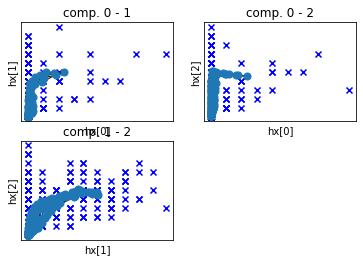

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0858  tErr : 0.8382
Epoch : 1 qErr : 0.0732  tErr : 0.8295
Epoch : 2 qErr : 0.0708  tErr : 0.8237
Epoch : 3 qErr : 0.0692  tErr : 0.8266
Epoch : 4 qErr : 0.0685  tErr : 0.8295
Epoch : 5 qErr : 0.0682  tErr : 0.8266
Epoch : 6 qErr : 0.0682  tErr : 0.8266
Epoch : 7 qErr : 0.0682  tErr : 0.8266
Epoch : 8 qErr : 0.0682  tErr : 0.8266
Epoch : 9 qErr : 0.0682  tErr : 0.8266


36it [06:20, 10.61s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1666  tErr : 0.6329
Epoch : 1 qErr : 0.1634  tErr : 0.6474
Epoch : 2 qErr : 0.1604  tErr : 0.6503
Epoch : 3 qErr : 0.1574  tErr : 0.6734
Epoch : 4 qErr : 0.1543  tErr : 0.6994
Epoch : 5 qErr : 0.1512  tErr : 0.7023
Epoch : 6 qErr : 0.1474  tErr : 0.7283
Epoch : 7 qErr : 0.1422  tErr : 0.7197
Epoch : 8 qErr : 0.1352  tErr : 0.7370
Epoch : 9 qErr : 0.1264  tErr : 0.7572


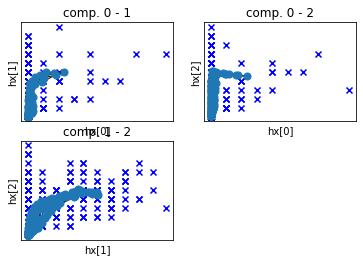

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1092  tErr : 0.7948
Epoch : 1 qErr : 0.1012  tErr : 0.7861
Epoch : 2 qErr : 0.0954  tErr : 0.7919
Epoch : 3 qErr : 0.0882  tErr : 0.8092
Epoch : 4 qErr : 0.0811  tErr : 0.8208
Epoch : 5 qErr : 0.0743  tErr : 0.8237
Epoch : 6 qErr : 0.0689  tErr : 0.8439
Epoch : 7 qErr : 0.0679  tErr : 0.8439
Epoch : 8 qErr : 0.0678  tErr : 0.8439
Epoch : 9 qErr : 0.0678  tErr : 0.8468


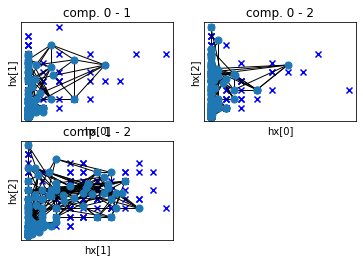

37it [06:31, 10.59s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1666  tErr : 0.6329
Epoch : 1 qErr : 0.1634  tErr : 0.6474
Epoch : 2 qErr : 0.1604  tErr : 0.6503
Epoch : 3 qErr : 0.1574  tErr : 0.6734
Epoch : 4 qErr : 0.1543  tErr : 0.6994
Epoch : 5 qErr : 0.1512  tErr : 0.7023
Epoch : 6 qErr : 0.1474  tErr : 0.7283
Epoch : 7 qErr : 0.1422  tErr : 0.7197
Epoch : 8 qErr : 0.1352  tErr : 0.7370
Epoch : 9 qErr : 0.1264  tErr : 0.7572


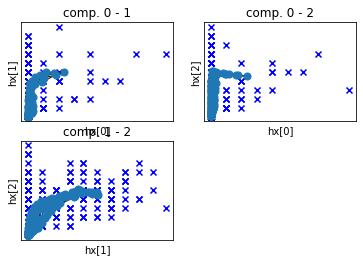

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1211  tErr : 0.7775
Epoch : 1 qErr : 0.1164  tErr : 0.7601
Epoch : 2 qErr : 0.1120  tErr : 0.7572
Epoch : 3 qErr : 0.1071  tErr : 0.7688
Epoch : 4 qErr : 0.1008  tErr : 0.7832
Epoch : 5 qErr : 0.0933  tErr : 0.7948
Epoch : 6 qErr : 0.0831  tErr : 0.8179
Epoch : 7 qErr : 0.0731  tErr : 0.8295
Epoch : 8 qErr : 0.0707  tErr : 0.8295
Epoch : 9 qErr : 0.0703  tErr : 0.8295


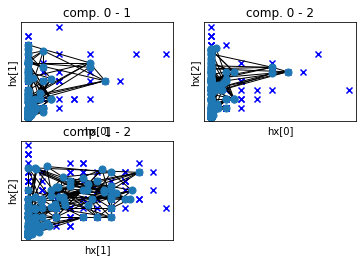

38it [06:41, 10.60s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1666  tErr : 0.6329
Epoch : 1 qErr : 0.1634  tErr : 0.6474
Epoch : 2 qErr : 0.1604  tErr : 0.6503
Epoch : 3 qErr : 0.1574  tErr : 0.6734
Epoch : 4 qErr : 0.1543  tErr : 0.6994
Epoch : 5 qErr : 0.1512  tErr : 0.7023
Epoch : 6 qErr : 0.1474  tErr : 0.7283
Epoch : 7 qErr : 0.1422  tErr : 0.7197
Epoch : 8 qErr : 0.1352  tErr : 0.7370
Epoch : 9 qErr : 0.1264  tErr : 0.7572


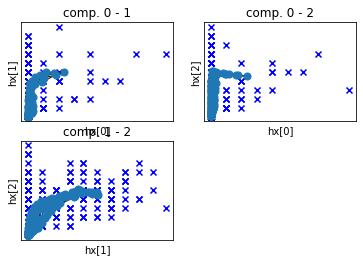

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1291  tErr : 0.7630
Epoch : 1 qErr : 0.1253  tErr : 0.7601
Epoch : 2 qErr : 0.1215  tErr : 0.7688
Epoch : 3 qErr : 0.1170  tErr : 0.7659
Epoch : 4 qErr : 0.1111  tErr : 0.7688
Epoch : 5 qErr : 0.1044  tErr : 0.7746
Epoch : 6 qErr : 0.0950  tErr : 0.7861
Epoch : 7 qErr : 0.0807  tErr : 0.8121
Epoch : 8 qErr : 0.0713  tErr : 0.8295
Epoch : 9 qErr : 0.0702  tErr : 0.8295


39it [06:52, 10.55s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1666  tErr : 0.6329
Epoch : 1 qErr : 0.1634  tErr : 0.6474
Epoch : 2 qErr : 0.1604  tErr : 0.6503
Epoch : 3 qErr : 0.1574  tErr : 0.6734
Epoch : 4 qErr : 0.1543  tErr : 0.6994
Epoch : 5 qErr : 0.1512  tErr : 0.7023
Epoch : 6 qErr : 0.1474  tErr : 0.7283
Epoch : 7 qErr : 0.1422  tErr : 0.7197
Epoch : 8 qErr : 0.1352  tErr : 0.7370
Epoch : 9 qErr : 0.1264  tErr : 0.7572


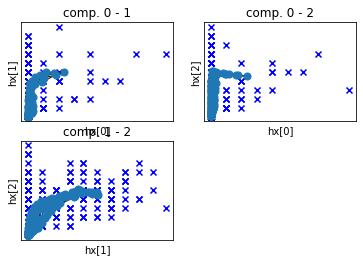

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1348  tErr : 0.7601
Epoch : 1 qErr : 0.1315  tErr : 0.7543
Epoch : 2 qErr : 0.1282  tErr : 0.7688
Epoch : 3 qErr : 0.1242  tErr : 0.7572
Epoch : 4 qErr : 0.1192  tErr : 0.7572
Epoch : 5 qErr : 0.1122  tErr : 0.7746
Epoch : 6 qErr : 0.1031  tErr : 0.7775
Epoch : 7 qErr : 0.0902  tErr : 0.7803
Epoch : 8 qErr : 0.0739  tErr : 0.8353
Epoch : 9 qErr : 0.0704  tErr : 0.8353


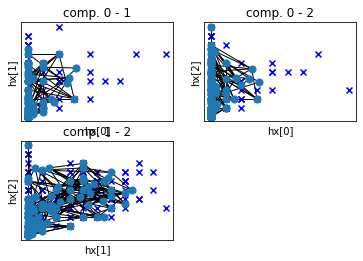

40it [07:03, 10.74s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1666  tErr : 0.6329
Epoch : 1 qErr : 0.1634  tErr : 0.6474
Epoch : 2 qErr : 0.1604  tErr : 0.6503
Epoch : 3 qErr : 0.1574  tErr : 0.6734
Epoch : 4 qErr : 0.1543  tErr : 0.6994
Epoch : 5 qErr : 0.1512  tErr : 0.7023
Epoch : 6 qErr : 0.1474  tErr : 0.7283
Epoch : 7 qErr : 0.1422  tErr : 0.7197
Epoch : 8 qErr : 0.1352  tErr : 0.7370
Epoch : 9 qErr : 0.1264  tErr : 0.7572


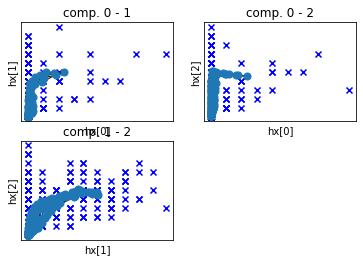

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1393  tErr : 0.7543
Epoch : 1 qErr : 0.1358  tErr : 0.7514
Epoch : 2 qErr : 0.1328  tErr : 0.7572
Epoch : 3 qErr : 0.1293  tErr : 0.7659
Epoch : 4 qErr : 0.1248  tErr : 0.7659
Epoch : 5 qErr : 0.1187  tErr : 0.7688
Epoch : 6 qErr : 0.1103  tErr : 0.7803
Epoch : 7 qErr : 0.0972  tErr : 0.7861
Epoch : 8 qErr : 0.0766  tErr : 0.8295
Epoch : 9 qErr : 0.0712  tErr : 0.8410


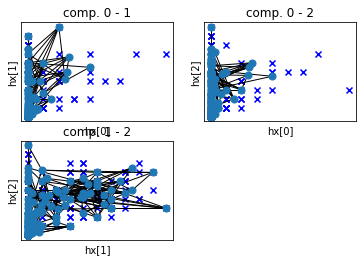

41it [07:15, 11.11s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1666  tErr : 0.6329
Epoch : 1 qErr : 0.1634  tErr : 0.6474
Epoch : 2 qErr : 0.1604  tErr : 0.6503
Epoch : 3 qErr : 0.1574  tErr : 0.6734
Epoch : 4 qErr : 0.1543  tErr : 0.6994
Epoch : 5 qErr : 0.1512  tErr : 0.7023
Epoch : 6 qErr : 0.1474  tErr : 0.7283
Epoch : 7 qErr : 0.1422  tErr : 0.7197
Epoch : 8 qErr : 0.1352  tErr : 0.7370
Epoch : 9 qErr : 0.1264  tErr : 0.7572


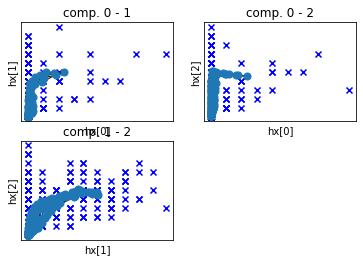

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1434  tErr : 0.7225
Epoch : 1 qErr : 0.1400  tErr : 0.7341
Epoch : 2 qErr : 0.1368  tErr : 0.7514
Epoch : 3 qErr : 0.1333  tErr : 0.7601
Epoch : 4 qErr : 0.1291  tErr : 0.7688
Epoch : 5 qErr : 0.1237  tErr : 0.7717
Epoch : 6 qErr : 0.1157  tErr : 0.8035
Epoch : 7 qErr : 0.1030  tErr : 0.7861
Epoch : 8 qErr : 0.0803  tErr : 0.8092
Epoch : 9 qErr : 0.0719  tErr : 0.8179


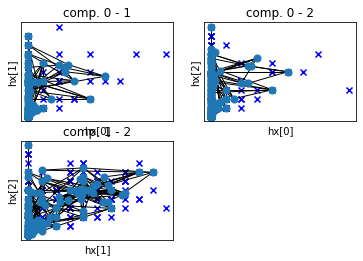

42it [07:27, 11.46s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1700  tErr : 0.6012
Epoch : 1 qErr : 0.1668  tErr : 0.6301
Epoch : 2 qErr : 0.1639  tErr : 0.6445
Epoch : 3 qErr : 0.1605  tErr : 0.6445
Epoch : 4 qErr : 0.1570  tErr : 0.6676
Epoch : 5 qErr : 0.1533  tErr : 0.7023
Epoch : 6 qErr : 0.1496  tErr : 0.7197
Epoch : 7 qErr : 0.1445  tErr : 0.7283
Epoch : 8 qErr : 0.1367  tErr : 0.7370
Epoch : 9 qErr : 0.1270  tErr : 0.7543


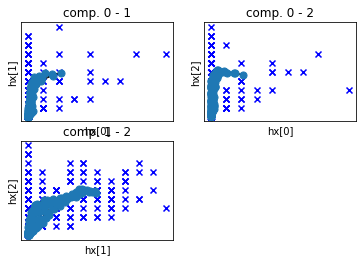

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0838  tErr : 0.8092
Epoch : 1 qErr : 0.0737  tErr : 0.8208
Epoch : 2 qErr : 0.0700  tErr : 0.8208
Epoch : 3 qErr : 0.0690  tErr : 0.8237
Epoch : 4 qErr : 0.0686  tErr : 0.8208
Epoch : 5 qErr : 0.0683  tErr : 0.8179
Epoch : 6 qErr : 0.0679  tErr : 0.8121
Epoch : 7 qErr : 0.0679  tErr : 0.8121
Epoch : 8 qErr : 0.0679  tErr : 0.8121
Epoch : 9 qErr : 0.0679  tErr : 0.8092


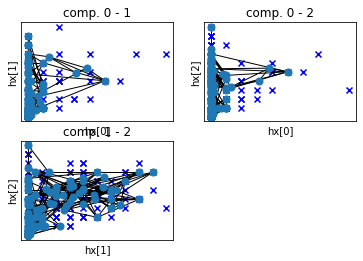

43it [07:39, 11.49s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1700  tErr : 0.6012
Epoch : 1 qErr : 0.1668  tErr : 0.6301
Epoch : 2 qErr : 0.1639  tErr : 0.6445
Epoch : 3 qErr : 0.1605  tErr : 0.6445
Epoch : 4 qErr : 0.1570  tErr : 0.6676
Epoch : 5 qErr : 0.1533  tErr : 0.7023
Epoch : 6 qErr : 0.1496  tErr : 0.7197
Epoch : 7 qErr : 0.1445  tErr : 0.7283
Epoch : 8 qErr : 0.1367  tErr : 0.7370
Epoch : 9 qErr : 0.1270  tErr : 0.7543


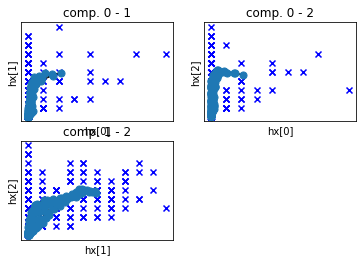

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1098  tErr : 0.7746
Epoch : 1 qErr : 0.1027  tErr : 0.7977
Epoch : 2 qErr : 0.0962  tErr : 0.8006
Epoch : 3 qErr : 0.0898  tErr : 0.8121
Epoch : 4 qErr : 0.0830  tErr : 0.8179
Epoch : 5 qErr : 0.0765  tErr : 0.8324
Epoch : 6 qErr : 0.0707  tErr : 0.8410
Epoch : 7 qErr : 0.0693  tErr : 0.8382
Epoch : 8 qErr : 0.0692  tErr : 0.8382
Epoch : 9 qErr : 0.0692  tErr : 0.8382


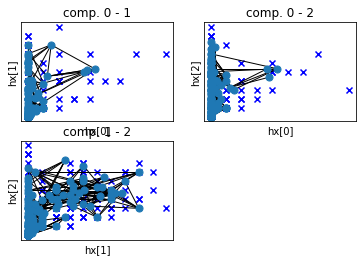

44it [07:50, 11.29s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1700  tErr : 0.6012
Epoch : 1 qErr : 0.1668  tErr : 0.6301
Epoch : 2 qErr : 0.1639  tErr : 0.6445
Epoch : 3 qErr : 0.1605  tErr : 0.6445
Epoch : 4 qErr : 0.1570  tErr : 0.6676
Epoch : 5 qErr : 0.1533  tErr : 0.7023
Epoch : 6 qErr : 0.1496  tErr : 0.7197
Epoch : 7 qErr : 0.1445  tErr : 0.7283
Epoch : 8 qErr : 0.1367  tErr : 0.7370
Epoch : 9 qErr : 0.1270  tErr : 0.7543


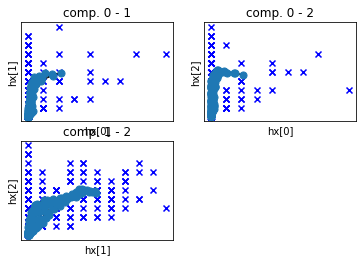

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1211  tErr : 0.7803
Epoch : 1 qErr : 0.1170  tErr : 0.7832
Epoch : 2 qErr : 0.1125  tErr : 0.7659
Epoch : 3 qErr : 0.1072  tErr : 0.7775
Epoch : 4 qErr : 0.1007  tErr : 0.7890
Epoch : 5 qErr : 0.0929  tErr : 0.7919
Epoch : 6 qErr : 0.0829  tErr : 0.8064
Epoch : 7 qErr : 0.0728  tErr : 0.8295
Epoch : 8 qErr : 0.0697  tErr : 0.8410
Epoch : 9 qErr : 0.0689  tErr : 0.8410


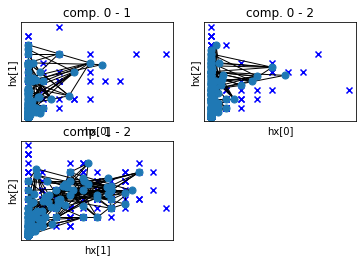

45it [08:00, 11.04s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1700  tErr : 0.6012
Epoch : 1 qErr : 0.1668  tErr : 0.6301
Epoch : 2 qErr : 0.1639  tErr : 0.6445
Epoch : 3 qErr : 0.1605  tErr : 0.6445
Epoch : 4 qErr : 0.1570  tErr : 0.6676
Epoch : 5 qErr : 0.1533  tErr : 0.7023
Epoch : 6 qErr : 0.1496  tErr : 0.7197
Epoch : 7 qErr : 0.1445  tErr : 0.7283
Epoch : 8 qErr : 0.1367  tErr : 0.7370
Epoch : 9 qErr : 0.1270  tErr : 0.7543


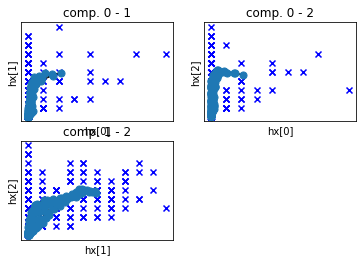

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1290  tErr : 0.7630
Epoch : 1 qErr : 0.1255  tErr : 0.7717
Epoch : 2 qErr : 0.1219  tErr : 0.7746
Epoch : 3 qErr : 0.1172  tErr : 0.7659
Epoch : 4 qErr : 0.1117  tErr : 0.7514
Epoch : 5 qErr : 0.1048  tErr : 0.7688
Epoch : 6 qErr : 0.0952  tErr : 0.7775
Epoch : 7 qErr : 0.0822  tErr : 0.7977
Epoch : 8 qErr : 0.0732  tErr : 0.8150
Epoch : 9 qErr : 0.0723  tErr : 0.8179


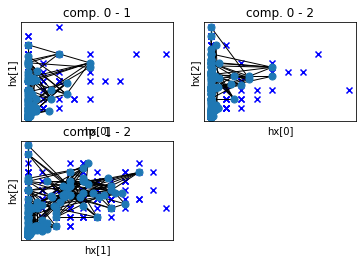

46it [08:10, 10.85s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1700  tErr : 0.6012
Epoch : 1 qErr : 0.1668  tErr : 0.6301
Epoch : 2 qErr : 0.1639  tErr : 0.6445
Epoch : 3 qErr : 0.1605  tErr : 0.6445
Epoch : 4 qErr : 0.1570  tErr : 0.6676
Epoch : 5 qErr : 0.1533  tErr : 0.7023
Epoch : 6 qErr : 0.1496  tErr : 0.7197
Epoch : 7 qErr : 0.1445  tErr : 0.7283
Epoch : 8 qErr : 0.1367  tErr : 0.7370
Epoch : 9 qErr : 0.1270  tErr : 0.7543


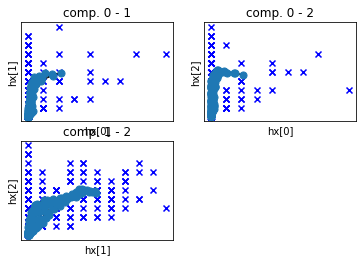

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1346  tErr : 0.7572
Epoch : 1 qErr : 0.1313  tErr : 0.7717
Epoch : 2 qErr : 0.1282  tErr : 0.7659
Epoch : 3 qErr : 0.1243  tErr : 0.7803
Epoch : 4 qErr : 0.1194  tErr : 0.7688
Epoch : 5 qErr : 0.1131  tErr : 0.7630
Epoch : 6 qErr : 0.1047  tErr : 0.7659
Epoch : 7 qErr : 0.0905  tErr : 0.7775
Epoch : 8 qErr : 0.0712  tErr : 0.8150
Epoch : 9 qErr : 0.0675  tErr : 0.8064


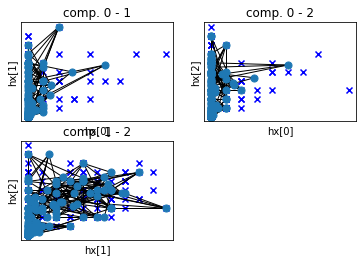

47it [08:21, 10.73s/it]

new best score 0.7903225806451613
new best config {'epochs': 10, 't_pahse1': 8, 't_phase2': 0, 't_pahse2': 1.9}
Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1700  tErr : 0.6012
Epoch : 1 qErr : 0.1668  tErr : 0.6301
Epoch : 2 qErr : 0.1639  tErr : 0.6445
Epoch : 3 qErr : 0.1605  tErr : 0.6445
Epoch : 4 qErr : 0.1570  tErr : 0.6676
Epoch : 5 qErr : 0.1533  tErr : 0.7023
Epoch : 6 qErr : 0.1496  tErr : 0.7197
Epoch : 7 qErr : 0.1445  tErr : 0.7283
Epoch : 8 qErr : 0.1367  tErr : 0.7370
Epoch : 9 qErr : 0.1270  tErr : 0.7543


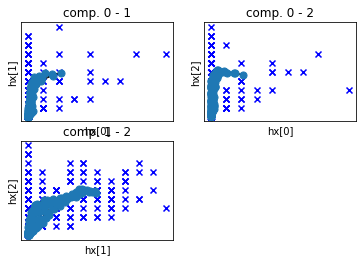

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1393  tErr : 0.7572
Epoch : 1 qErr : 0.1358  tErr : 0.7399
Epoch : 2 qErr : 0.1327  tErr : 0.7572
Epoch : 3 qErr : 0.1293  tErr : 0.7746
Epoch : 4 qErr : 0.1248  tErr : 0.7659
Epoch : 5 qErr : 0.1188  tErr : 0.7688
Epoch : 6 qErr : 0.1107  tErr : 0.7746
Epoch : 7 qErr : 0.0976  tErr : 0.7746
Epoch : 8 qErr : 0.0767  tErr : 0.8150
Epoch : 9 qErr : 0.0711  tErr : 0.8150


48it [08:31, 10.63s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1700  tErr : 0.6012
Epoch : 1 qErr : 0.1668  tErr : 0.6301
Epoch : 2 qErr : 0.1639  tErr : 0.6445
Epoch : 3 qErr : 0.1605  tErr : 0.6445
Epoch : 4 qErr : 0.1570  tErr : 0.6676
Epoch : 5 qErr : 0.1533  tErr : 0.7023
Epoch : 6 qErr : 0.1496  tErr : 0.7197
Epoch : 7 qErr : 0.1445  tErr : 0.7283
Epoch : 8 qErr : 0.1367  tErr : 0.7370
Epoch : 9 qErr : 0.1270  tErr : 0.7543


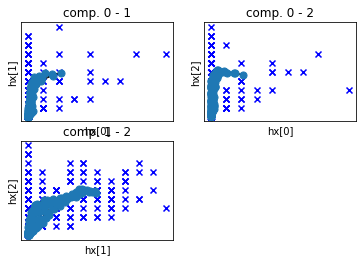

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1434  tErr : 0.7399
Epoch : 1 qErr : 0.1400  tErr : 0.7370
Epoch : 2 qErr : 0.1368  tErr : 0.7486
Epoch : 3 qErr : 0.1332  tErr : 0.7659
Epoch : 4 qErr : 0.1290  tErr : 0.7832
Epoch : 5 qErr : 0.1235  tErr : 0.7919
Epoch : 6 qErr : 0.1155  tErr : 0.7948
Epoch : 7 qErr : 0.1027  tErr : 0.7890
Epoch : 8 qErr : 0.0804  tErr : 0.8064
Epoch : 9 qErr : 0.0721  tErr : 0.8035


49it [08:42, 10.70s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1726  tErr : 0.5751
Epoch : 1 qErr : 0.1696  tErr : 0.5867
Epoch : 2 qErr : 0.1669  tErr : 0.6243
Epoch : 3 qErr : 0.1635  tErr : 0.6416
Epoch : 4 qErr : 0.1596  tErr : 0.6618
Epoch : 5 qErr : 0.1555  tErr : 0.6850
Epoch : 6 qErr : 0.1513  tErr : 0.7110
Epoch : 7 qErr : 0.1463  tErr : 0.7312
Epoch : 8 qErr : 0.1386  tErr : 0.7341
Epoch : 9 qErr : 0.1279  tErr : 0.7428


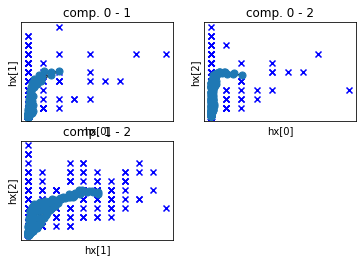

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0872  tErr : 0.8410
Epoch : 1 qErr : 0.0746  tErr : 0.8324
Epoch : 2 qErr : 0.0713  tErr : 0.8353
Epoch : 3 qErr : 0.0704  tErr : 0.8353
Epoch : 4 qErr : 0.0704  tErr : 0.8353
Epoch : 5 qErr : 0.0704  tErr : 0.8353
Epoch : 6 qErr : 0.0704  tErr : 0.8353
Epoch : 7 qErr : 0.0704  tErr : 0.8353
Epoch : 8 qErr : 0.0704  tErr : 0.8353
Epoch : 9 qErr : 0.0704  tErr : 0.8382


50it [08:53, 10.75s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1726  tErr : 0.5751
Epoch : 1 qErr : 0.1696  tErr : 0.5867
Epoch : 2 qErr : 0.1669  tErr : 0.6243
Epoch : 3 qErr : 0.1635  tErr : 0.6416
Epoch : 4 qErr : 0.1596  tErr : 0.6618
Epoch : 5 qErr : 0.1555  tErr : 0.6850
Epoch : 6 qErr : 0.1513  tErr : 0.7110
Epoch : 7 qErr : 0.1463  tErr : 0.7312
Epoch : 8 qErr : 0.1386  tErr : 0.7341
Epoch : 9 qErr : 0.1279  tErr : 0.7428


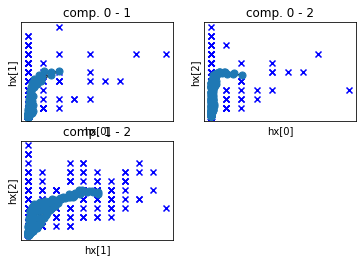

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1114  tErr : 0.7890
Epoch : 1 qErr : 0.1042  tErr : 0.7775
Epoch : 2 qErr : 0.0977  tErr : 0.7919
Epoch : 3 qErr : 0.0910  tErr : 0.7977
Epoch : 4 qErr : 0.0840  tErr : 0.8092
Epoch : 5 qErr : 0.0768  tErr : 0.8439
Epoch : 6 qErr : 0.0729  tErr : 0.8468
Epoch : 7 qErr : 0.0716  tErr : 0.8526
Epoch : 8 qErr : 0.0716  tErr : 0.8526
Epoch : 9 qErr : 0.0716  tErr : 0.8526


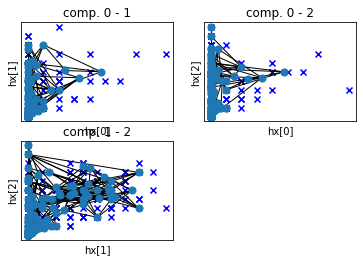

51it [09:04, 10.69s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1726  tErr : 0.5751
Epoch : 1 qErr : 0.1696  tErr : 0.5867
Epoch : 2 qErr : 0.1669  tErr : 0.6243
Epoch : 3 qErr : 0.1635  tErr : 0.6416
Epoch : 4 qErr : 0.1596  tErr : 0.6618
Epoch : 5 qErr : 0.1555  tErr : 0.6850
Epoch : 6 qErr : 0.1513  tErr : 0.7110
Epoch : 7 qErr : 0.1463  tErr : 0.7312
Epoch : 8 qErr : 0.1386  tErr : 0.7341
Epoch : 9 qErr : 0.1279  tErr : 0.7428


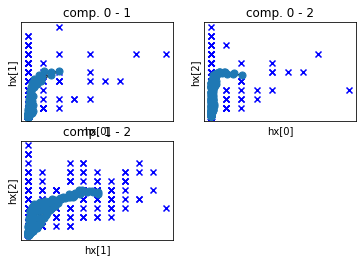

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1226  tErr : 0.7717
Epoch : 1 qErr : 0.1178  tErr : 0.7717
Epoch : 2 qErr : 0.1129  tErr : 0.7688
Epoch : 3 qErr : 0.1075  tErr : 0.7775
Epoch : 4 qErr : 0.1014  tErr : 0.7977
Epoch : 5 qErr : 0.0929  tErr : 0.8006
Epoch : 6 qErr : 0.0823  tErr : 0.8064
Epoch : 7 qErr : 0.0716  tErr : 0.8439
Epoch : 8 qErr : 0.0688  tErr : 0.8439
Epoch : 9 qErr : 0.0684  tErr : 0.8468


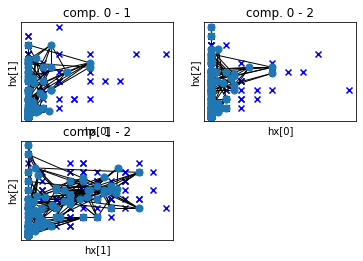

52it [09:14, 10.61s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1726  tErr : 0.5751
Epoch : 1 qErr : 0.1696  tErr : 0.5867
Epoch : 2 qErr : 0.1669  tErr : 0.6243
Epoch : 3 qErr : 0.1635  tErr : 0.6416
Epoch : 4 qErr : 0.1596  tErr : 0.6618
Epoch : 5 qErr : 0.1555  tErr : 0.6850
Epoch : 6 qErr : 0.1513  tErr : 0.7110
Epoch : 7 qErr : 0.1463  tErr : 0.7312
Epoch : 8 qErr : 0.1386  tErr : 0.7341
Epoch : 9 qErr : 0.1279  tErr : 0.7428


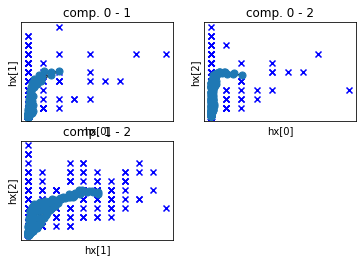

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1298  tErr : 0.7572
Epoch : 1 qErr : 0.1259  tErr : 0.7659
Epoch : 2 qErr : 0.1223  tErr : 0.7775
Epoch : 3 qErr : 0.1179  tErr : 0.7861
Epoch : 4 qErr : 0.1122  tErr : 0.7630
Epoch : 5 qErr : 0.1045  tErr : 0.7630
Epoch : 6 qErr : 0.0946  tErr : 0.7630
Epoch : 7 qErr : 0.0798  tErr : 0.8006
Epoch : 8 qErr : 0.0692  tErr : 0.8353
Epoch : 9 qErr : 0.0686  tErr : 0.8353


53it [09:25, 10.63s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1726  tErr : 0.5751
Epoch : 1 qErr : 0.1696  tErr : 0.5867
Epoch : 2 qErr : 0.1669  tErr : 0.6243
Epoch : 3 qErr : 0.1635  tErr : 0.6416
Epoch : 4 qErr : 0.1596  tErr : 0.6618
Epoch : 5 qErr : 0.1555  tErr : 0.6850
Epoch : 6 qErr : 0.1513  tErr : 0.7110
Epoch : 7 qErr : 0.1463  tErr : 0.7312
Epoch : 8 qErr : 0.1386  tErr : 0.7341
Epoch : 9 qErr : 0.1279  tErr : 0.7428


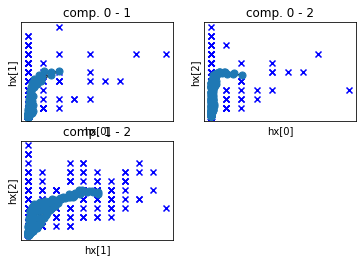

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1352  tErr : 0.7572
Epoch : 1 qErr : 0.1318  tErr : 0.7486
Epoch : 2 qErr : 0.1287  tErr : 0.7803
Epoch : 3 qErr : 0.1251  tErr : 0.7775
Epoch : 4 qErr : 0.1195  tErr : 0.7746
Epoch : 5 qErr : 0.1127  tErr : 0.7803
Epoch : 6 qErr : 0.1031  tErr : 0.7861
Epoch : 7 qErr : 0.0900  tErr : 0.7977
Epoch : 8 qErr : 0.0730  tErr : 0.8526
Epoch : 9 qErr : 0.0694  tErr : 0.8613


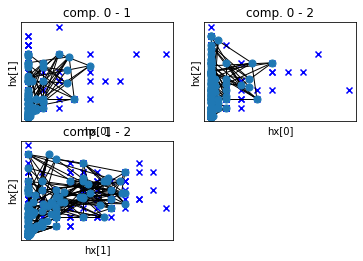

54it [09:35, 10.61s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1726  tErr : 0.5751
Epoch : 1 qErr : 0.1696  tErr : 0.5867
Epoch : 2 qErr : 0.1669  tErr : 0.6243
Epoch : 3 qErr : 0.1635  tErr : 0.6416
Epoch : 4 qErr : 0.1596  tErr : 0.6618
Epoch : 5 qErr : 0.1555  tErr : 0.6850
Epoch : 6 qErr : 0.1513  tErr : 0.7110
Epoch : 7 qErr : 0.1463  tErr : 0.7312
Epoch : 8 qErr : 0.1386  tErr : 0.7341
Epoch : 9 qErr : 0.1279  tErr : 0.7428


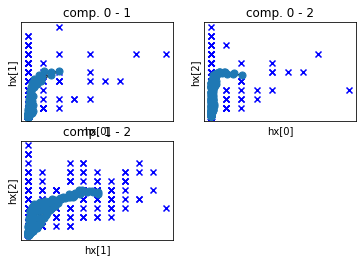

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1397  tErr : 0.7370
Epoch : 1 qErr : 0.1360  tErr : 0.7370
Epoch : 2 qErr : 0.1332  tErr : 0.7543
Epoch : 3 qErr : 0.1298  tErr : 0.7717
Epoch : 4 qErr : 0.1253  tErr : 0.7775
Epoch : 5 qErr : 0.1193  tErr : 0.7832
Epoch : 6 qErr : 0.1106  tErr : 0.7861
Epoch : 7 qErr : 0.0967  tErr : 0.7977
Epoch : 8 qErr : 0.0756  tErr : 0.8208
Epoch : 9 qErr : 0.0707  tErr : 0.8295


55it [09:46, 10.58s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.1726  tErr : 0.5751
Epoch : 1 qErr : 0.1696  tErr : 0.5867
Epoch : 2 qErr : 0.1669  tErr : 0.6243
Epoch : 3 qErr : 0.1635  tErr : 0.6416
Epoch : 4 qErr : 0.1596  tErr : 0.6618
Epoch : 5 qErr : 0.1555  tErr : 0.6850
Epoch : 6 qErr : 0.1513  tErr : 0.7110
Epoch : 7 qErr : 0.1463  tErr : 0.7312
Epoch : 8 qErr : 0.1386  tErr : 0.7341
Epoch : 9 qErr : 0.1279  tErr : 0.7428


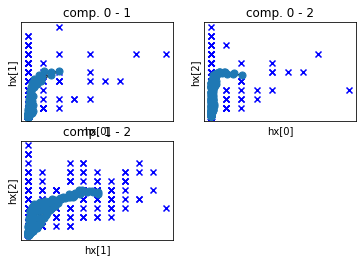

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1436  tErr : 0.7283
Epoch : 1 qErr : 0.1401  tErr : 0.7312
Epoch : 2 qErr : 0.1370  tErr : 0.7370
Epoch : 3 qErr : 0.1336  tErr : 0.7630
Epoch : 4 qErr : 0.1293  tErr : 0.7890
Epoch : 5 qErr : 0.1238  tErr : 0.7890
Epoch : 6 qErr : 0.1157  tErr : 0.7948
Epoch : 7 qErr : 0.1030  tErr : 0.7861
Epoch : 8 qErr : 0.0804  tErr : 0.7948
Epoch : 9 qErr : 0.0707  tErr : 0.8035


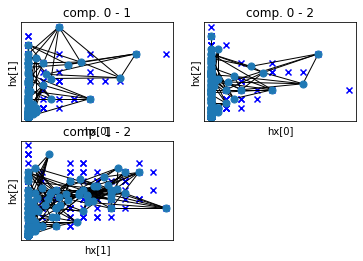

56it [09:56, 10.59s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1384  tErr : 0.7890
Epoch : 2 qErr : 0.1368  tErr : 0.7861
Epoch : 3 qErr : 0.1355  tErr : 0.7832
Epoch : 4 qErr : 0.1347  tErr : 0.7630
Epoch : 5 qErr : 0.1338  tErr : 0.7803
Epoch : 6 qErr : 0.1333  tErr : 0.7775
Epoch : 7 qErr : 0.1328  tErr : 0.7688
Epoch : 8 qErr : 0.1322  tErr : 0.7717
Epoch : 9 qErr : 0.1317  tErr : 0.7803
Epoch : 10 qErr : 0.1311  tErr : 0.7977
Epoch : 11 qErr : 0.1306  tErr : 0.7861
Epoch : 12 qErr : 0.1300  tErr : 0.7861
Epoch : 13 qErr : 0.1295  tErr : 0.7832
Epoch : 14 qErr : 0.1289  tErr : 0.7919
Epoch : 15 qErr : 0.1284  tErr : 0.7861
Epoch : 16 qErr : 0.1279  tErr : 0.7890
Epoch : 17 qErr : 0.1274  tErr : 0.7832
Epoch : 18 qErr : 0.1270  tErr : 0.7861
Epoch : 19 qErr : 0.1265  tErr : 0.7832
Epoch : 20 qErr : 0.1260  tErr : 0.7861
Epoch : 21 qErr : 0.1254  tErr : 0.7919
Epoch : 22 qErr : 0.1248  tErr : 0.7861
Epo

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.0807  tErr : 0.8353
Epoch : 1 qErr : 0.0721  tErr : 0.8266
Epoch : 2 qErr : 0.0692  tErr : 0.8382
Epoch : 3 qErr : 0.0687  tErr : 0.8382
Epoch : 4 qErr : 0.0685  tErr : 0.8382
Epoch : 5 qErr : 0.0684  tErr : 0.8382
Epoch : 6 qErr : 0.0683  tErr : 0.8382
Epoch : 7 qErr : 0.0683  tErr : 0.8382
Epoch : 8 qErr : 0.0682  tErr : 0.8410
Epoch : 9 qErr : 0.0682  tErr : 0.8410
Epoch : 10 qErr : 0.0682  tErr : 0.8410
Epoch : 11 qErr : 0.0682  tErr : 0.8410
Epoch : 12 qErr : 0.0682  tErr : 0.8410
Epoch : 13 qErr : 0.0682  tErr : 0.8410
Epoch : 14 qErr : 0.0682  tErr : 0.8410
Epoch : 15 qErr : 0.0682  tErr : 0.8410
Epoch : 16 qErr : 0.0682  tErr : 0.8410
Epoch : 17 qErr : 0.0682  tErr : 0.8410
Epoch : 18 qErr : 0.0682  tErr : 0.8410
Epoch : 19 qErr : 0.0682  tErr : 0.8410
Epoch : 20 qErr : 0.0682  tErr : 0.8410
Epoch : 21 qErr : 0.0682  tErr : 0.8410
Epoch : 22 qErr : 0.0682  tErr : 0.8410
Epoch : 23 qErr :

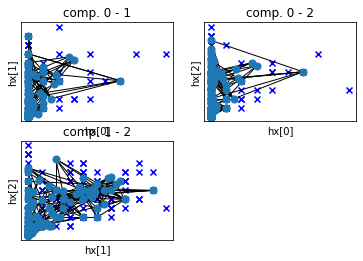

57it [10:24, 15.58s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1384  tErr : 0.7890
Epoch : 2 qErr : 0.1368  tErr : 0.7861
Epoch : 3 qErr : 0.1355  tErr : 0.7832
Epoch : 4 qErr : 0.1347  tErr : 0.7630
Epoch : 5 qErr : 0.1338  tErr : 0.7803
Epoch : 6 qErr : 0.1333  tErr : 0.7775
Epoch : 7 qErr : 0.1328  tErr : 0.7688
Epoch : 8 qErr : 0.1322  tErr : 0.7717
Epoch : 9 qErr : 0.1317  tErr : 0.7803
Epoch : 10 qErr : 0.1311  tErr : 0.7977
Epoch : 11 qErr : 0.1306  tErr : 0.7861
Epoch : 12 qErr : 0.1300  tErr : 0.7861
Epoch : 13 qErr : 0.1295  tErr : 0.7832
Epoch : 14 qErr : 0.1289  tErr : 0.7919
Epoch : 15 qErr : 0.1284  tErr : 0.7861
Epoch : 16 qErr : 0.1279  tErr : 0.7890
Epoch : 17 qErr : 0.1274  tErr : 0.7832
Epoch : 18 qErr : 0.1270  tErr : 0.7861
Epoch : 19 qErr : 0.1265  tErr : 0.7832
Epoch : 20 qErr : 0.1260  tErr : 0.7861
Epoch : 21 qErr : 0.1254  tErr : 0.7919
Epoch : 22 qErr : 0.1248  tErr : 0.7861
Epo

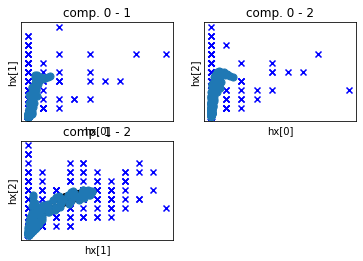

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1034  tErr : 0.7688
Epoch : 1 qErr : 0.1003  tErr : 0.7775
Epoch : 2 qErr : 0.0982  tErr : 0.7717
Epoch : 3 qErr : 0.0967  tErr : 0.7861
Epoch : 4 qErr : 0.0954  tErr : 0.7919
Epoch : 5 qErr : 0.0940  tErr : 0.7948
Epoch : 6 qErr : 0.0925  tErr : 0.8006
Epoch : 7 qErr : 0.0909  tErr : 0.7977
Epoch : 8 qErr : 0.0893  tErr : 0.7977
Epoch : 9 qErr : 0.0876  tErr : 0.7919
Epoch : 10 qErr : 0.0857  tErr : 0.7948
Epoch : 11 qErr : 0.0838  tErr : 0.8121
Epoch : 12 qErr : 0.0817  tErr : 0.8150
Epoch : 13 qErr : 0.0798  tErr : 0.8179
Epoch : 14 qErr : 0.0777  tErr : 0.8295
Epoch : 15 qErr : 0.0757  tErr : 0.8237
Epoch : 16 qErr : 0.0737  tErr : 0.8237
Epoch : 17 qErr : 0.0719  tErr : 0.8382
Epoch : 18 qErr : 0.0707  tErr : 0.8382
Epoch : 19 qErr : 0.0698  tErr : 0.8382
Epoch : 20 qErr : 0.0692  tErr : 0.8410
Epoch : 21 qErr : 0.0684  tErr : 0.8439
Epoch : 22 qErr : 0.0682  tErr : 0.8468
Epoch : 23 qErr :

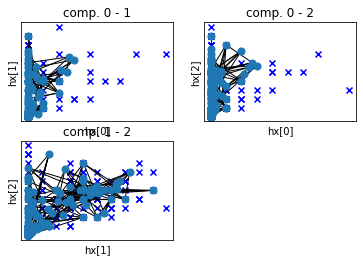

58it [10:50, 18.96s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1384  tErr : 0.7890
Epoch : 2 qErr : 0.1368  tErr : 0.7861
Epoch : 3 qErr : 0.1355  tErr : 0.7832
Epoch : 4 qErr : 0.1347  tErr : 0.7630
Epoch : 5 qErr : 0.1338  tErr : 0.7803
Epoch : 6 qErr : 0.1333  tErr : 0.7775
Epoch : 7 qErr : 0.1328  tErr : 0.7688
Epoch : 8 qErr : 0.1322  tErr : 0.7717
Epoch : 9 qErr : 0.1317  tErr : 0.7803
Epoch : 10 qErr : 0.1311  tErr : 0.7977
Epoch : 11 qErr : 0.1306  tErr : 0.7861
Epoch : 12 qErr : 0.1300  tErr : 0.7861
Epoch : 13 qErr : 0.1295  tErr : 0.7832
Epoch : 14 qErr : 0.1289  tErr : 0.7919
Epoch : 15 qErr : 0.1284  tErr : 0.7861
Epoch : 16 qErr : 0.1279  tErr : 0.7890
Epoch : 17 qErr : 0.1274  tErr : 0.7832
Epoch : 18 qErr : 0.1270  tErr : 0.7861
Epoch : 19 qErr : 0.1265  tErr : 0.7832
Epoch : 20 qErr : 0.1260  tErr : 0.7861
Epoch : 21 qErr : 0.1254  tErr : 0.7919
Epoch : 22 qErr : 0.1248  tErr : 0.7861
Epo

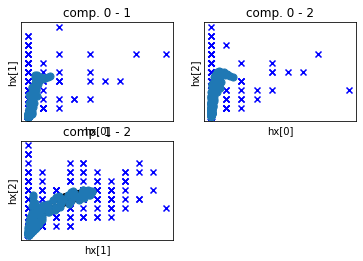

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1165  tErr : 0.7717
Epoch : 1 qErr : 0.1154  tErr : 0.7832
Epoch : 2 qErr : 0.1144  tErr : 0.7890
Epoch : 3 qErr : 0.1132  tErr : 0.7832
Epoch : 4 qErr : 0.1120  tErr : 0.7832
Epoch : 5 qErr : 0.1107  tErr : 0.7832
Epoch : 6 qErr : 0.1094  tErr : 0.7832
Epoch : 7 qErr : 0.1081  tErr : 0.7832
Epoch : 8 qErr : 0.1067  tErr : 0.7746
Epoch : 9 qErr : 0.1051  tErr : 0.7688
Epoch : 10 qErr : 0.1036  tErr : 0.7659
Epoch : 11 qErr : 0.1018  tErr : 0.7630
Epoch : 12 qErr : 0.1000  tErr : 0.7688
Epoch : 13 qErr : 0.0980  tErr : 0.7746
Epoch : 14 qErr : 0.0960  tErr : 0.7775
Epoch : 15 qErr : 0.0939  tErr : 0.7861
Epoch : 16 qErr : 0.0916  tErr : 0.7919
Epoch : 17 qErr : 0.0891  tErr : 0.7919
Epoch : 18 qErr : 0.0864  tErr : 0.8006
Epoch : 19 qErr : 0.0828  tErr : 0.8208
Epoch : 20 qErr : 0.0796  tErr : 0.8179
Epoch : 21 qErr : 0.0761  tErr : 0.8208
Epoch : 22 qErr : 0.0729  tErr : 0.8324
Epoch : 23 qErr :

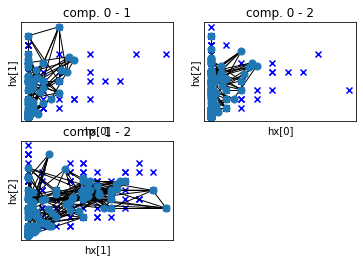

59it [11:17, 21.38s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1384  tErr : 0.7890
Epoch : 2 qErr : 0.1368  tErr : 0.7861
Epoch : 3 qErr : 0.1355  tErr : 0.7832
Epoch : 4 qErr : 0.1347  tErr : 0.7630
Epoch : 5 qErr : 0.1338  tErr : 0.7803
Epoch : 6 qErr : 0.1333  tErr : 0.7775
Epoch : 7 qErr : 0.1328  tErr : 0.7688
Epoch : 8 qErr : 0.1322  tErr : 0.7717
Epoch : 9 qErr : 0.1317  tErr : 0.7803
Epoch : 10 qErr : 0.1311  tErr : 0.7977
Epoch : 11 qErr : 0.1306  tErr : 0.7861
Epoch : 12 qErr : 0.1300  tErr : 0.7861
Epoch : 13 qErr : 0.1295  tErr : 0.7832
Epoch : 14 qErr : 0.1289  tErr : 0.7919
Epoch : 15 qErr : 0.1284  tErr : 0.7861
Epoch : 16 qErr : 0.1279  tErr : 0.7890
Epoch : 17 qErr : 0.1274  tErr : 0.7832
Epoch : 18 qErr : 0.1270  tErr : 0.7861
Epoch : 19 qErr : 0.1265  tErr : 0.7832
Epoch : 20 qErr : 0.1260  tErr : 0.7861
Epoch : 21 qErr : 0.1254  tErr : 0.7919
Epoch : 22 qErr : 0.1248  tErr : 0.7861
Epo

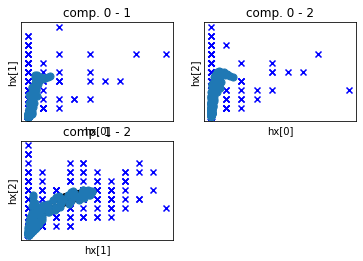

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1263  tErr : 0.7832
Epoch : 1 qErr : 0.1252  tErr : 0.7803
Epoch : 2 qErr : 0.1241  tErr : 0.7861
Epoch : 3 qErr : 0.1230  tErr : 0.7803
Epoch : 4 qErr : 0.1219  tErr : 0.7775
Epoch : 5 qErr : 0.1207  tErr : 0.7775
Epoch : 6 qErr : 0.1194  tErr : 0.7775
Epoch : 7 qErr : 0.1181  tErr : 0.7803
Epoch : 8 qErr : 0.1167  tErr : 0.7832
Epoch : 9 qErr : 0.1153  tErr : 0.7832
Epoch : 10 qErr : 0.1138  tErr : 0.7861
Epoch : 11 qErr : 0.1122  tErr : 0.7832
Epoch : 12 qErr : 0.1104  tErr : 0.7803
Epoch : 13 qErr : 0.1088  tErr : 0.7746
Epoch : 14 qErr : 0.1067  tErr : 0.7688
Epoch : 15 qErr : 0.1045  tErr : 0.7688
Epoch : 16 qErr : 0.1021  tErr : 0.7630
Epoch : 17 qErr : 0.0995  tErr : 0.7630
Epoch : 18 qErr : 0.0967  tErr : 0.7717
Epoch : 19 qErr : 0.0938  tErr : 0.7832
Epoch : 20 qErr : 0.0904  tErr : 0.7919
Epoch : 21 qErr : 0.0869  tErr : 0.8064
Epoch : 22 qErr : 0.0823  tErr : 0.8266
Epoch : 23 qErr :

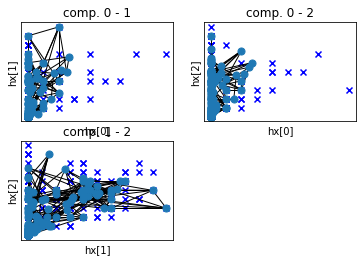

60it [11:45, 23.09s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1384  tErr : 0.7890
Epoch : 2 qErr : 0.1368  tErr : 0.7861
Epoch : 3 qErr : 0.1355  tErr : 0.7832
Epoch : 4 qErr : 0.1347  tErr : 0.7630
Epoch : 5 qErr : 0.1338  tErr : 0.7803
Epoch : 6 qErr : 0.1333  tErr : 0.7775
Epoch : 7 qErr : 0.1328  tErr : 0.7688
Epoch : 8 qErr : 0.1322  tErr : 0.7717
Epoch : 9 qErr : 0.1317  tErr : 0.7803
Epoch : 10 qErr : 0.1311  tErr : 0.7977
Epoch : 11 qErr : 0.1306  tErr : 0.7861
Epoch : 12 qErr : 0.1300  tErr : 0.7861
Epoch : 13 qErr : 0.1295  tErr : 0.7832
Epoch : 14 qErr : 0.1289  tErr : 0.7919
Epoch : 15 qErr : 0.1284  tErr : 0.7861
Epoch : 16 qErr : 0.1279  tErr : 0.7890
Epoch : 17 qErr : 0.1274  tErr : 0.7832
Epoch : 18 qErr : 0.1270  tErr : 0.7861
Epoch : 19 qErr : 0.1265  tErr : 0.7832
Epoch : 20 qErr : 0.1260  tErr : 0.7861
Epoch : 21 qErr : 0.1254  tErr : 0.7919
Epoch : 22 qErr : 0.1248  tErr : 0.7861
Epo

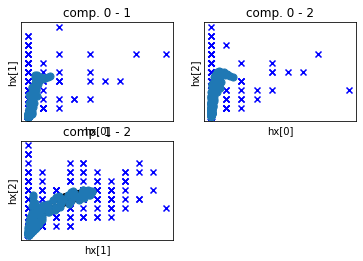

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1337  tErr : 0.7919
Epoch : 1 qErr : 0.1325  tErr : 0.7948
Epoch : 2 qErr : 0.1314  tErr : 0.7948
Epoch : 3 qErr : 0.1302  tErr : 0.7919
Epoch : 4 qErr : 0.1291  tErr : 0.7890
Epoch : 5 qErr : 0.1279  tErr : 0.7890
Epoch : 6 qErr : 0.1266  tErr : 0.7861
Epoch : 7 qErr : 0.1254  tErr : 0.7803
Epoch : 8 qErr : 0.1241  tErr : 0.7832
Epoch : 9 qErr : 0.1227  tErr : 0.7803
Epoch : 10 qErr : 0.1212  tErr : 0.7688
Epoch : 11 qErr : 0.1197  tErr : 0.7746
Epoch : 12 qErr : 0.1181  tErr : 0.7659
Epoch : 13 qErr : 0.1163  tErr : 0.7688
Epoch : 14 qErr : 0.1143  tErr : 0.7775
Epoch : 15 qErr : 0.1123  tErr : 0.7746
Epoch : 16 qErr : 0.1101  tErr : 0.7717
Epoch : 17 qErr : 0.1077  tErr : 0.7630
Epoch : 18 qErr : 0.1051  tErr : 0.7659
Epoch : 19 qErr : 0.1022  tErr : 0.7601
Epoch : 20 qErr : 0.0989  tErr : 0.7659
Epoch : 21 qErr : 0.0948  tErr : 0.7832
Epoch : 22 qErr : 0.0905  tErr : 0.7861
Epoch : 23 qErr :

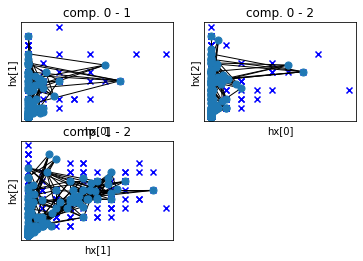

61it [12:11, 24.18s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1384  tErr : 0.7890
Epoch : 2 qErr : 0.1368  tErr : 0.7861
Epoch : 3 qErr : 0.1355  tErr : 0.7832
Epoch : 4 qErr : 0.1347  tErr : 0.7630
Epoch : 5 qErr : 0.1338  tErr : 0.7803
Epoch : 6 qErr : 0.1333  tErr : 0.7775
Epoch : 7 qErr : 0.1328  tErr : 0.7688
Epoch : 8 qErr : 0.1322  tErr : 0.7717
Epoch : 9 qErr : 0.1317  tErr : 0.7803
Epoch : 10 qErr : 0.1311  tErr : 0.7977
Epoch : 11 qErr : 0.1306  tErr : 0.7861
Epoch : 12 qErr : 0.1300  tErr : 0.7861
Epoch : 13 qErr : 0.1295  tErr : 0.7832
Epoch : 14 qErr : 0.1289  tErr : 0.7919
Epoch : 15 qErr : 0.1284  tErr : 0.7861
Epoch : 16 qErr : 0.1279  tErr : 0.7890
Epoch : 17 qErr : 0.1274  tErr : 0.7832
Epoch : 18 qErr : 0.1270  tErr : 0.7861
Epoch : 19 qErr : 0.1265  tErr : 0.7832
Epoch : 20 qErr : 0.1260  tErr : 0.7861
Epoch : 21 qErr : 0.1254  tErr : 0.7919
Epoch : 22 qErr : 0.1248  tErr : 0.7861
Epo

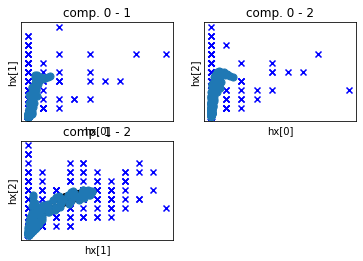

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1396  tErr : 0.7803
Epoch : 1 qErr : 0.1383  tErr : 0.7746
Epoch : 2 qErr : 0.1372  tErr : 0.7775
Epoch : 3 qErr : 0.1360  tErr : 0.7803
Epoch : 4 qErr : 0.1349  tErr : 0.7803
Epoch : 5 qErr : 0.1338  tErr : 0.7890
Epoch : 6 qErr : 0.1327  tErr : 0.7890
Epoch : 7 qErr : 0.1314  tErr : 0.8006
Epoch : 8 qErr : 0.1302  tErr : 0.7948
Epoch : 9 qErr : 0.1288  tErr : 0.7919
Epoch : 10 qErr : 0.1274  tErr : 0.7890
Epoch : 11 qErr : 0.1258  tErr : 0.7832
Epoch : 12 qErr : 0.1240  tErr : 0.7890
Epoch : 13 qErr : 0.1223  tErr : 0.7861
Epoch : 14 qErr : 0.1205  tErr : 0.7746
Epoch : 15 qErr : 0.1183  tErr : 0.7717
Epoch : 16 qErr : 0.1160  tErr : 0.7746
Epoch : 17 qErr : 0.1136  tErr : 0.7890
Epoch : 18 qErr : 0.1111  tErr : 0.7861
Epoch : 19 qErr : 0.1082  tErr : 0.7775
Epoch : 20 qErr : 0.1049  tErr : 0.7775
Epoch : 21 qErr : 0.1011  tErr : 0.7746
Epoch : 22 qErr : 0.0968  tErr : 0.7832
Epoch : 23 qErr :

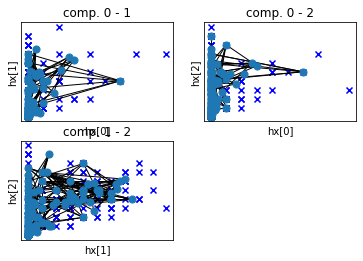

62it [12:38, 25.01s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1448  tErr : 0.7717
Epoch : 1 qErr : 0.1384  tErr : 0.7890
Epoch : 2 qErr : 0.1368  tErr : 0.7861
Epoch : 3 qErr : 0.1355  tErr : 0.7832
Epoch : 4 qErr : 0.1347  tErr : 0.7630
Epoch : 5 qErr : 0.1338  tErr : 0.7803
Epoch : 6 qErr : 0.1333  tErr : 0.7775
Epoch : 7 qErr : 0.1328  tErr : 0.7688
Epoch : 8 qErr : 0.1322  tErr : 0.7717
Epoch : 9 qErr : 0.1317  tErr : 0.7803
Epoch : 10 qErr : 0.1311  tErr : 0.7977
Epoch : 11 qErr : 0.1306  tErr : 0.7861
Epoch : 12 qErr : 0.1300  tErr : 0.7861
Epoch : 13 qErr : 0.1295  tErr : 0.7832
Epoch : 14 qErr : 0.1289  tErr : 0.7919
Epoch : 15 qErr : 0.1284  tErr : 0.7861
Epoch : 16 qErr : 0.1279  tErr : 0.7890
Epoch : 17 qErr : 0.1274  tErr : 0.7832
Epoch : 18 qErr : 0.1270  tErr : 0.7861
Epoch : 19 qErr : 0.1265  tErr : 0.7832
Epoch : 20 qErr : 0.1260  tErr : 0.7861
Epoch : 21 qErr : 0.1254  tErr : 0.7919
Epoch : 22 qErr : 0.1248  tErr : 0.7861
Epo

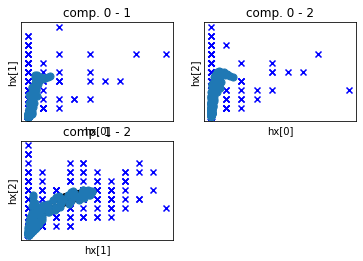

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1443  tErr : 0.7659
Epoch : 1 qErr : 0.1424  tErr : 0.7601
Epoch : 2 qErr : 0.1412  tErr : 0.7601
Epoch : 3 qErr : 0.1401  tErr : 0.7659
Epoch : 4 qErr : 0.1391  tErr : 0.7630
Epoch : 5 qErr : 0.1379  tErr : 0.7746
Epoch : 6 qErr : 0.1368  tErr : 0.7861
Epoch : 7 qErr : 0.1356  tErr : 0.7861
Epoch : 8 qErr : 0.1343  tErr : 0.7919
Epoch : 9 qErr : 0.1332  tErr : 0.7919
Epoch : 10 qErr : 0.1318  tErr : 0.7832
Epoch : 11 qErr : 0.1305  tErr : 0.7832
Epoch : 12 qErr : 0.1291  tErr : 0.7688
Epoch : 13 qErr : 0.1276  tErr : 0.7688
Epoch : 14 qErr : 0.1255  tErr : 0.7775
Epoch : 15 qErr : 0.1237  tErr : 0.7717
Epoch : 16 qErr : 0.1213  tErr : 0.7659
Epoch : 17 qErr : 0.1187  tErr : 0.7630
Epoch : 18 qErr : 0.1159  tErr : 0.7630
Epoch : 19 qErr : 0.1129  tErr : 0.7688
Epoch : 20 qErr : 0.1095  tErr : 0.7630
Epoch : 21 qErr : 0.1058  tErr : 0.7659
Epoch : 22 qErr : 0.1014  tErr : 0.7659
Epoch : 23 qErr :

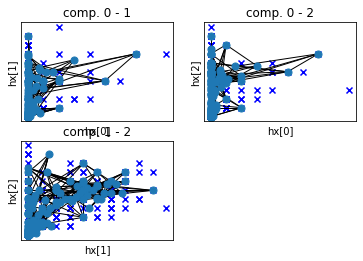

63it [13:05, 25.57s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1464  tErr : 0.7370
Epoch : 2 qErr : 0.1455  tErr : 0.7457
Epoch : 3 qErr : 0.1447  tErr : 0.7428
Epoch : 4 qErr : 0.1440  tErr : 0.7341
Epoch : 5 qErr : 0.1434  tErr : 0.7370
Epoch : 6 qErr : 0.1428  tErr : 0.7312
Epoch : 7 qErr : 0.1421  tErr : 0.7283
Epoch : 8 qErr : 0.1414  tErr : 0.7370
Epoch : 9 qErr : 0.1406  tErr : 0.7370
Epoch : 10 qErr : 0.1400  tErr : 0.7399
Epoch : 11 qErr : 0.1393  tErr : 0.7428
Epoch : 12 qErr : 0.1386  tErr : 0.7457
Epoch : 13 qErr : 0.1379  tErr : 0.7428
Epoch : 14 qErr : 0.1370  tErr : 0.7572
Epoch : 15 qErr : 0.1363  tErr : 0.7572
Epoch : 16 qErr : 0.1355  tErr : 0.7601
Epoch : 17 qErr : 0.1346  tErr : 0.7572
Epoch : 18 qErr : 0.1338  tErr : 0.7601
Epoch : 19 qErr : 0.1329  tErr : 0.7659
Epoch : 20 qErr : 0.1321  tErr : 0.7572
Epoch : 21 qErr : 0.1311  tErr : 0.7630
Epoch : 22 qErr : 0.1302  tErr : 0.7659
Epo

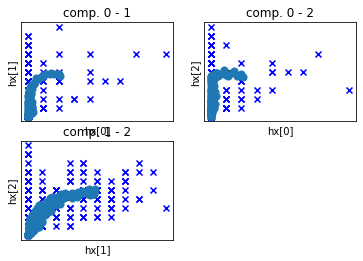

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.0848  tErr : 0.8266
Epoch : 1 qErr : 0.0772  tErr : 0.8035
Epoch : 2 qErr : 0.0730  tErr : 0.8092
Epoch : 3 qErr : 0.0722  tErr : 0.8092
Epoch : 4 qErr : 0.0720  tErr : 0.8092
Epoch : 5 qErr : 0.0719  tErr : 0.8092
Epoch : 6 qErr : 0.0718  tErr : 0.8092
Epoch : 7 qErr : 0.0717  tErr : 0.8092
Epoch : 8 qErr : 0.0717  tErr : 0.8092
Epoch : 9 qErr : 0.0717  tErr : 0.8092
Epoch : 10 qErr : 0.0717  tErr : 0.8092
Epoch : 11 qErr : 0.0717  tErr : 0.8092
Epoch : 12 qErr : 0.0717  tErr : 0.8092
Epoch : 13 qErr : 0.0717  tErr : 0.8092
Epoch : 14 qErr : 0.0717  tErr : 0.8092
Epoch : 15 qErr : 0.0717  tErr : 0.8092
Epoch : 16 qErr : 0.0717  tErr : 0.8092
Epoch : 17 qErr : 0.0717  tErr : 0.8092
Epoch : 18 qErr : 0.0717  tErr : 0.8092
Epoch : 19 qErr : 0.0717  tErr : 0.8092
Epoch : 20 qErr : 0.0717  tErr : 0.8092
Epoch : 21 qErr : 0.0717  tErr : 0.8092
Epoch : 22 qErr : 0.0717  tErr : 0.8092
Epoch : 23 qErr :

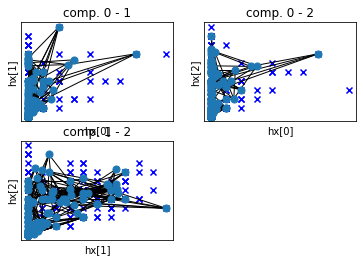

64it [13:32, 25.99s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1464  tErr : 0.7370
Epoch : 2 qErr : 0.1455  tErr : 0.7457
Epoch : 3 qErr : 0.1447  tErr : 0.7428
Epoch : 4 qErr : 0.1440  tErr : 0.7341
Epoch : 5 qErr : 0.1434  tErr : 0.7370
Epoch : 6 qErr : 0.1428  tErr : 0.7312
Epoch : 7 qErr : 0.1421  tErr : 0.7283
Epoch : 8 qErr : 0.1414  tErr : 0.7370
Epoch : 9 qErr : 0.1406  tErr : 0.7370
Epoch : 10 qErr : 0.1400  tErr : 0.7399
Epoch : 11 qErr : 0.1393  tErr : 0.7428
Epoch : 12 qErr : 0.1386  tErr : 0.7457
Epoch : 13 qErr : 0.1379  tErr : 0.7428
Epoch : 14 qErr : 0.1370  tErr : 0.7572
Epoch : 15 qErr : 0.1363  tErr : 0.7572
Epoch : 16 qErr : 0.1355  tErr : 0.7601
Epoch : 17 qErr : 0.1346  tErr : 0.7572
Epoch : 18 qErr : 0.1338  tErr : 0.7601
Epoch : 19 qErr : 0.1329  tErr : 0.7659
Epoch : 20 qErr : 0.1321  tErr : 0.7572
Epoch : 21 qErr : 0.1311  tErr : 0.7630
Epoch : 22 qErr : 0.1302  tErr : 0.7659
Epo

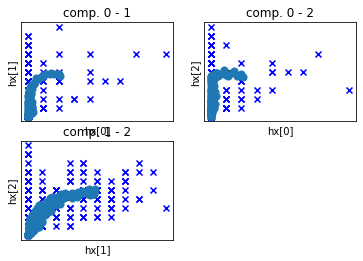

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1052  tErr : 0.7775
Epoch : 1 qErr : 0.1016  tErr : 0.7803
Epoch : 2 qErr : 0.0996  tErr : 0.7861
Epoch : 3 qErr : 0.0980  tErr : 0.7890
Epoch : 4 qErr : 0.0966  tErr : 0.7890
Epoch : 5 qErr : 0.0952  tErr : 0.7948
Epoch : 6 qErr : 0.0939  tErr : 0.7977
Epoch : 7 qErr : 0.0925  tErr : 0.8006
Epoch : 8 qErr : 0.0911  tErr : 0.8006
Epoch : 9 qErr : 0.0895  tErr : 0.8035
Epoch : 10 qErr : 0.0880  tErr : 0.8006
Epoch : 11 qErr : 0.0865  tErr : 0.8035
Epoch : 12 qErr : 0.0848  tErr : 0.8035
Epoch : 13 qErr : 0.0830  tErr : 0.8092
Epoch : 14 qErr : 0.0810  tErr : 0.8064
Epoch : 15 qErr : 0.0790  tErr : 0.8006
Epoch : 16 qErr : 0.0774  tErr : 0.8035
Epoch : 17 qErr : 0.0759  tErr : 0.8064
Epoch : 18 qErr : 0.0746  tErr : 0.8121
Epoch : 19 qErr : 0.0738  tErr : 0.8150
Epoch : 20 qErr : 0.0733  tErr : 0.8150
Epoch : 21 qErr : 0.0730  tErr : 0.8150
Epoch : 22 qErr : 0.0729  tErr : 0.8150
Epoch : 23 qErr :

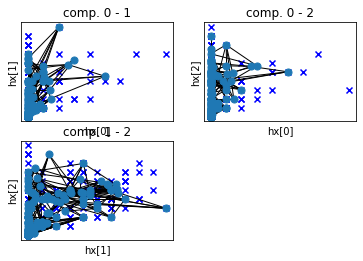

65it [13:59, 26.26s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1464  tErr : 0.7370
Epoch : 2 qErr : 0.1455  tErr : 0.7457
Epoch : 3 qErr : 0.1447  tErr : 0.7428
Epoch : 4 qErr : 0.1440  tErr : 0.7341
Epoch : 5 qErr : 0.1434  tErr : 0.7370
Epoch : 6 qErr : 0.1428  tErr : 0.7312
Epoch : 7 qErr : 0.1421  tErr : 0.7283
Epoch : 8 qErr : 0.1414  tErr : 0.7370
Epoch : 9 qErr : 0.1406  tErr : 0.7370
Epoch : 10 qErr : 0.1400  tErr : 0.7399
Epoch : 11 qErr : 0.1393  tErr : 0.7428
Epoch : 12 qErr : 0.1386  tErr : 0.7457
Epoch : 13 qErr : 0.1379  tErr : 0.7428
Epoch : 14 qErr : 0.1370  tErr : 0.7572
Epoch : 15 qErr : 0.1363  tErr : 0.7572
Epoch : 16 qErr : 0.1355  tErr : 0.7601
Epoch : 17 qErr : 0.1346  tErr : 0.7572
Epoch : 18 qErr : 0.1338  tErr : 0.7601
Epoch : 19 qErr : 0.1329  tErr : 0.7659
Epoch : 20 qErr : 0.1321  tErr : 0.7572
Epoch : 21 qErr : 0.1311  tErr : 0.7630
Epoch : 22 qErr : 0.1302  tErr : 0.7659
Epo

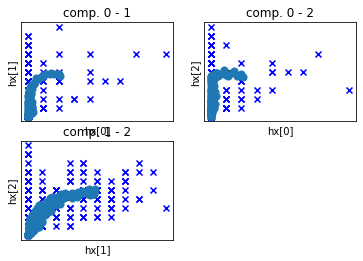

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1181  tErr : 0.7688
Epoch : 1 qErr : 0.1168  tErr : 0.7746
Epoch : 2 qErr : 0.1155  tErr : 0.7775
Epoch : 3 qErr : 0.1139  tErr : 0.7717
Epoch : 4 qErr : 0.1124  tErr : 0.7746
Epoch : 5 qErr : 0.1108  tErr : 0.7775
Epoch : 6 qErr : 0.1095  tErr : 0.7746
Epoch : 7 qErr : 0.1082  tErr : 0.7775
Epoch : 8 qErr : 0.1066  tErr : 0.7717
Epoch : 9 qErr : 0.1049  tErr : 0.7832
Epoch : 10 qErr : 0.1035  tErr : 0.7803
Epoch : 11 qErr : 0.1020  tErr : 0.7861
Epoch : 12 qErr : 0.1003  tErr : 0.7861
Epoch : 13 qErr : 0.0984  tErr : 0.7775
Epoch : 14 qErr : 0.0965  tErr : 0.7803
Epoch : 15 qErr : 0.0944  tErr : 0.7890
Epoch : 16 qErr : 0.0923  tErr : 0.7890
Epoch : 17 qErr : 0.0895  tErr : 0.7948
Epoch : 18 qErr : 0.0868  tErr : 0.8035
Epoch : 19 qErr : 0.0841  tErr : 0.8035
Epoch : 20 qErr : 0.0812  tErr : 0.8064
Epoch : 21 qErr : 0.0781  tErr : 0.8035
Epoch : 22 qErr : 0.0757  tErr : 0.8092
Epoch : 23 qErr :

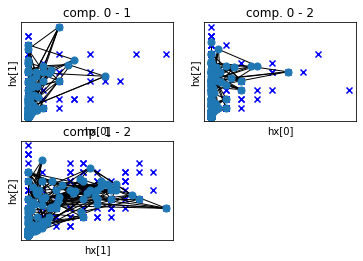

66it [14:26, 26.44s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1464  tErr : 0.7370
Epoch : 2 qErr : 0.1455  tErr : 0.7457
Epoch : 3 qErr : 0.1447  tErr : 0.7428
Epoch : 4 qErr : 0.1440  tErr : 0.7341
Epoch : 5 qErr : 0.1434  tErr : 0.7370
Epoch : 6 qErr : 0.1428  tErr : 0.7312
Epoch : 7 qErr : 0.1421  tErr : 0.7283
Epoch : 8 qErr : 0.1414  tErr : 0.7370
Epoch : 9 qErr : 0.1406  tErr : 0.7370
Epoch : 10 qErr : 0.1400  tErr : 0.7399
Epoch : 11 qErr : 0.1393  tErr : 0.7428
Epoch : 12 qErr : 0.1386  tErr : 0.7457
Epoch : 13 qErr : 0.1379  tErr : 0.7428
Epoch : 14 qErr : 0.1370  tErr : 0.7572
Epoch : 15 qErr : 0.1363  tErr : 0.7572
Epoch : 16 qErr : 0.1355  tErr : 0.7601
Epoch : 17 qErr : 0.1346  tErr : 0.7572
Epoch : 18 qErr : 0.1338  tErr : 0.7601
Epoch : 19 qErr : 0.1329  tErr : 0.7659
Epoch : 20 qErr : 0.1321  tErr : 0.7572
Epoch : 21 qErr : 0.1311  tErr : 0.7630
Epoch : 22 qErr : 0.1302  tErr : 0.7659
Epo

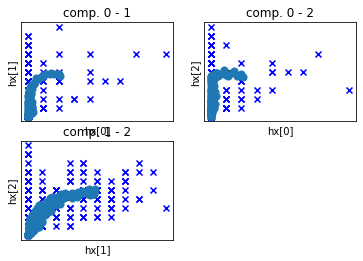

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1270  tErr : 0.7688
Epoch : 1 qErr : 0.1259  tErr : 0.7775
Epoch : 2 qErr : 0.1248  tErr : 0.7775
Epoch : 3 qErr : 0.1238  tErr : 0.7775
Epoch : 4 qErr : 0.1226  tErr : 0.7775
Epoch : 5 qErr : 0.1214  tErr : 0.7775
Epoch : 6 qErr : 0.1203  tErr : 0.7775
Epoch : 7 qErr : 0.1189  tErr : 0.7803
Epoch : 8 qErr : 0.1174  tErr : 0.7803
Epoch : 9 qErr : 0.1157  tErr : 0.7832
Epoch : 10 qErr : 0.1137  tErr : 0.7832
Epoch : 11 qErr : 0.1117  tErr : 0.7861
Epoch : 12 qErr : 0.1097  tErr : 0.7861
Epoch : 13 qErr : 0.1077  tErr : 0.7861
Epoch : 14 qErr : 0.1057  tErr : 0.7919
Epoch : 15 qErr : 0.1035  tErr : 0.7919
Epoch : 16 qErr : 0.1012  tErr : 0.7948
Epoch : 17 qErr : 0.0989  tErr : 0.7948
Epoch : 18 qErr : 0.0961  tErr : 0.8035
Epoch : 19 qErr : 0.0934  tErr : 0.8092
Epoch : 20 qErr : 0.0899  tErr : 0.8150
Epoch : 21 qErr : 0.0865  tErr : 0.8237
Epoch : 22 qErr : 0.0825  tErr : 0.8179
Epoch : 23 qErr :

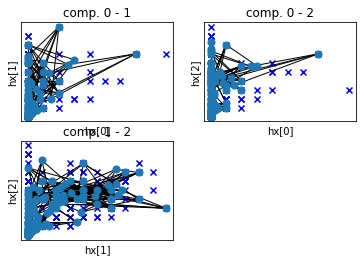

67it [14:53, 26.56s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1464  tErr : 0.7370
Epoch : 2 qErr : 0.1455  tErr : 0.7457
Epoch : 3 qErr : 0.1447  tErr : 0.7428
Epoch : 4 qErr : 0.1440  tErr : 0.7341
Epoch : 5 qErr : 0.1434  tErr : 0.7370
Epoch : 6 qErr : 0.1428  tErr : 0.7312
Epoch : 7 qErr : 0.1421  tErr : 0.7283
Epoch : 8 qErr : 0.1414  tErr : 0.7370
Epoch : 9 qErr : 0.1406  tErr : 0.7370
Epoch : 10 qErr : 0.1400  tErr : 0.7399
Epoch : 11 qErr : 0.1393  tErr : 0.7428
Epoch : 12 qErr : 0.1386  tErr : 0.7457
Epoch : 13 qErr : 0.1379  tErr : 0.7428
Epoch : 14 qErr : 0.1370  tErr : 0.7572
Epoch : 15 qErr : 0.1363  tErr : 0.7572
Epoch : 16 qErr : 0.1355  tErr : 0.7601
Epoch : 17 qErr : 0.1346  tErr : 0.7572
Epoch : 18 qErr : 0.1338  tErr : 0.7601
Epoch : 19 qErr : 0.1329  tErr : 0.7659
Epoch : 20 qErr : 0.1321  tErr : 0.7572
Epoch : 21 qErr : 0.1311  tErr : 0.7630
Epoch : 22 qErr : 0.1302  tErr : 0.7659
Epo

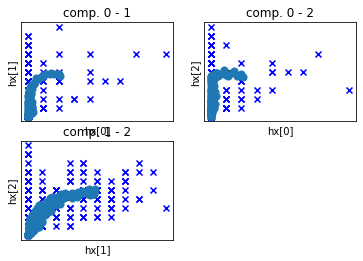

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1339  tErr : 0.7514
Epoch : 1 qErr : 0.1326  tErr : 0.7514
Epoch : 2 qErr : 0.1317  tErr : 0.7572
Epoch : 3 qErr : 0.1307  tErr : 0.7514
Epoch : 4 qErr : 0.1298  tErr : 0.7514
Epoch : 5 qErr : 0.1286  tErr : 0.7630
Epoch : 6 qErr : 0.1275  tErr : 0.7659
Epoch : 7 qErr : 0.1263  tErr : 0.7572
Epoch : 8 qErr : 0.1248  tErr : 0.7572
Epoch : 9 qErr : 0.1235  tErr : 0.7659
Epoch : 10 qErr : 0.1221  tErr : 0.7659
Epoch : 11 qErr : 0.1206  tErr : 0.7775
Epoch : 12 qErr : 0.1189  tErr : 0.7717
Epoch : 13 qErr : 0.1170  tErr : 0.7775
Epoch : 14 qErr : 0.1149  tErr : 0.7717
Epoch : 15 qErr : 0.1126  tErr : 0.7775
Epoch : 16 qErr : 0.1098  tErr : 0.7717
Epoch : 17 qErr : 0.1071  tErr : 0.7746
Epoch : 18 qErr : 0.1041  tErr : 0.7803
Epoch : 19 qErr : 0.1009  tErr : 0.7803
Epoch : 20 qErr : 0.0978  tErr : 0.7948
Epoch : 21 qErr : 0.0942  tErr : 0.8006
Epoch : 22 qErr : 0.0895  tErr : 0.8150
Epoch : 23 qErr :

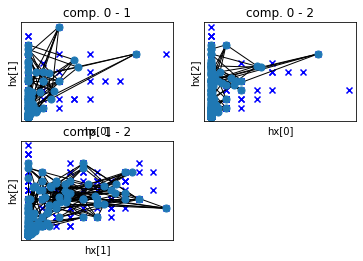

68it [15:20, 26.65s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1464  tErr : 0.7370
Epoch : 2 qErr : 0.1455  tErr : 0.7457
Epoch : 3 qErr : 0.1447  tErr : 0.7428
Epoch : 4 qErr : 0.1440  tErr : 0.7341
Epoch : 5 qErr : 0.1434  tErr : 0.7370
Epoch : 6 qErr : 0.1428  tErr : 0.7312
Epoch : 7 qErr : 0.1421  tErr : 0.7283
Epoch : 8 qErr : 0.1414  tErr : 0.7370
Epoch : 9 qErr : 0.1406  tErr : 0.7370
Epoch : 10 qErr : 0.1400  tErr : 0.7399
Epoch : 11 qErr : 0.1393  tErr : 0.7428
Epoch : 12 qErr : 0.1386  tErr : 0.7457
Epoch : 13 qErr : 0.1379  tErr : 0.7428
Epoch : 14 qErr : 0.1370  tErr : 0.7572
Epoch : 15 qErr : 0.1363  tErr : 0.7572
Epoch : 16 qErr : 0.1355  tErr : 0.7601
Epoch : 17 qErr : 0.1346  tErr : 0.7572
Epoch : 18 qErr : 0.1338  tErr : 0.7601
Epoch : 19 qErr : 0.1329  tErr : 0.7659
Epoch : 20 qErr : 0.1321  tErr : 0.7572
Epoch : 21 qErr : 0.1311  tErr : 0.7630
Epoch : 22 qErr : 0.1302  tErr : 0.7659
Epo

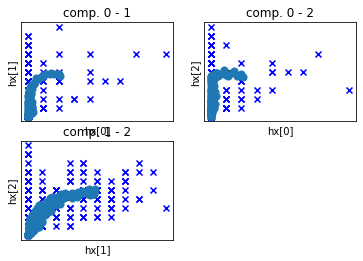

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1393  tErr : 0.7601
Epoch : 1 qErr : 0.1379  tErr : 0.7717
Epoch : 2 qErr : 0.1368  tErr : 0.7746
Epoch : 3 qErr : 0.1360  tErr : 0.7717
Epoch : 4 qErr : 0.1349  tErr : 0.7803
Epoch : 5 qErr : 0.1338  tErr : 0.7775
Epoch : 6 qErr : 0.1327  tErr : 0.7630
Epoch : 7 qErr : 0.1316  tErr : 0.7543
Epoch : 8 qErr : 0.1304  tErr : 0.7572
Epoch : 9 qErr : 0.1292  tErr : 0.7659
Epoch : 10 qErr : 0.1278  tErr : 0.7775
Epoch : 11 qErr : 0.1262  tErr : 0.7775
Epoch : 12 qErr : 0.1246  tErr : 0.7688
Epoch : 13 qErr : 0.1229  tErr : 0.7775
Epoch : 14 qErr : 0.1212  tErr : 0.7688
Epoch : 15 qErr : 0.1190  tErr : 0.7803
Epoch : 16 qErr : 0.1165  tErr : 0.7775
Epoch : 17 qErr : 0.1137  tErr : 0.7803
Epoch : 18 qErr : 0.1109  tErr : 0.7775
Epoch : 19 qErr : 0.1075  tErr : 0.7717
Epoch : 20 qErr : 0.1042  tErr : 0.7746
Epoch : 21 qErr : 0.1005  tErr : 0.7803
Epoch : 22 qErr : 0.0962  tErr : 0.7803
Epoch : 23 qErr :

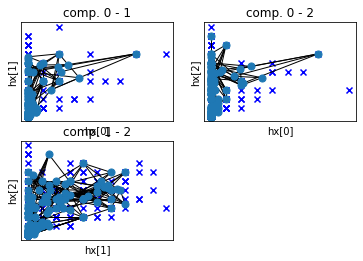

69it [15:47, 26.78s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.1489  tErr : 0.7486
Epoch : 1 qErr : 0.1464  tErr : 0.7370
Epoch : 2 qErr : 0.1455  tErr : 0.7457
Epoch : 3 qErr : 0.1447  tErr : 0.7428
Epoch : 4 qErr : 0.1440  tErr : 0.7341
Epoch : 5 qErr : 0.1434  tErr : 0.7370
Epoch : 6 qErr : 0.1428  tErr : 0.7312
Epoch : 7 qErr : 0.1421  tErr : 0.7283
Epoch : 8 qErr : 0.1414  tErr : 0.7370
Epoch : 9 qErr : 0.1406  tErr : 0.7370
Epoch : 10 qErr : 0.1400  tErr : 0.7399
Epoch : 11 qErr : 0.1393  tErr : 0.7428
Epoch : 12 qErr : 0.1386  tErr : 0.7457
Epoch : 13 qErr : 0.1379  tErr : 0.7428
Epoch : 14 qErr : 0.1370  tErr : 0.7572
Epoch : 15 qErr : 0.1363  tErr : 0.7572
Epoch : 16 qErr : 0.1355  tErr : 0.7601
Epoch : 17 qErr : 0.1346  tErr : 0.7572
Epoch : 18 qErr : 0.1338  tErr : 0.7601
Epoch : 19 qErr : 0.1329  tErr : 0.7659
Epoch : 20 qErr : 0.1321  tErr : 0.7572
Epoch : 21 qErr : 0.1311  tErr : 0.7630
Epoch : 22 qErr : 0.1302  tErr : 0.7659
Epo

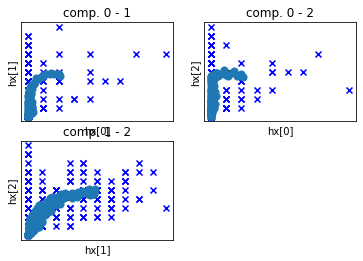

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1436  tErr : 0.7543
Epoch : 1 qErr : 0.1418  tErr : 0.7341
Epoch : 2 qErr : 0.1408  tErr : 0.7457
Epoch : 3 qErr : 0.1398  tErr : 0.7486
Epoch : 4 qErr : 0.1387  tErr : 0.7514
Epoch : 5 qErr : 0.1377  tErr : 0.7746
Epoch : 6 qErr : 0.1366  tErr : 0.7659
Epoch : 7 qErr : 0.1355  tErr : 0.7630
Epoch : 8 qErr : 0.1344  tErr : 0.7630
Epoch : 9 qErr : 0.1332  tErr : 0.7428
Epoch : 10 qErr : 0.1320  tErr : 0.7572
Epoch : 11 qErr : 0.1306  tErr : 0.7572
Epoch : 12 qErr : 0.1294  tErr : 0.7601
Epoch : 13 qErr : 0.1281  tErr : 0.7514
Epoch : 14 qErr : 0.1262  tErr : 0.7514
Epoch : 15 qErr : 0.1243  tErr : 0.7601
Epoch : 16 qErr : 0.1224  tErr : 0.7630
Epoch : 17 qErr : 0.1203  tErr : 0.7601
Epoch : 18 qErr : 0.1174  tErr : 0.7630
Epoch : 19 qErr : 0.1142  tErr : 0.7659
Epoch : 20 qErr : 0.1107  tErr : 0.7601
Epoch : 21 qErr : 0.1067  tErr : 0.7601
Epoch : 22 qErr : 0.1019  tErr : 0.7543
Epoch : 23 qErr :

69it [16:11, 14.07s/it]

Epoch : 25 qErr : 0.0844  tErr : 0.7659



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-b80a5075ad09>", line 37, in <module>
    watch_evolution = False)
  File "./sompyLatmos/decorators.py", line 11, in wrapped_f
    result = f(*args, **kwargs)
  File "./sompyLatmos/sompy.py", line 561, in train
    trainlen_factor=train_len_factor,maxtrainlen=maxtrainlen, watch_evolution = watch_evolution)
  File "./sompyLatmos/sompy.py", line 628, in finetune_train
    self._batchtrain(trainlen, radiusin, radiusfin, njob, shared_memory, watch_evolution = watch_evolution)
  File "./sompyLatmos/sompy.py", line 677, in _batchtrain
    bmu = self.find_bmu(data, njb=njob)
  File "./sompyLatmos/decorators.py", line 11, in wrapped_f
    result = f(*args, **kwargs)
  File "./sompyLatmos/sompy.py", line 748, in find_bmu
    pool.join()
  File "/home/moumene/.co

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-b80a5075ad09>", line 37, in <module>
    watch_evolution = False)
  File "./sompyLatmos/decorators.py", line 11, in wrapped_f
    result = f(*args, **kwargs)
  File "./sompyLatmos/sompy.py", line 561, in train
    trainlen_factor=train_len_factor,maxtrainlen=maxtrainlen, watch_evolution = watch_evolution)
  File "./sompyLatmos/sompy.py", line 628, in finetune_train
    self._batchtrain(trainlen, radiusin, radiusfin, njob, shared_memory, watch_evolution = watch_evolution)
  File "./sompyLatmos/sompy.py", line 677, in _batchtrain
    bmu = self.find_bmu(data, njb=njob)
  File "./sompyLatmos/decorators.py", line 11, in wrapped_f
    result = f(*args, **kwargs)
  File "./sompyLatmos/sompy.py", line 748, in find_bmu
    pool.join()
  File "/home/moumene/.co

In [ ]:
from tqdm import tqdm 
import math
from sklearn.metrics import accuracy_score

best_configs = {}
best_val_scores = {}

for i,data in enumerate(encodage): 
    data_dev, data_test, data_labels_dev, data_labels_test = train_test_split(data, data_labels, test_size=0.15, random_state=42)
    data_train, data_val, data_labels_train, data_labels_val = train_test_split(data_dev, data_labels_dev, test_size=0.15, random_state=42)
    sData_train = SOMData(data_train,
                composante_names[i],# les données 
                data_labels_train)
    sm = SOMFactory().build(sData_train, 
                        mapsize=mapsize,
                        normalization = None, 
                        #initialization='random', # obligatoire pour x
                        initialization='pca',  
                        radius_train ='linear', 
                        name='Des Chiffres',
                        #lattice='rect',
                        lattice='hexa',
                        mask=np.ones(len(composante_names[i])),
                        components_to_plot=((0,1),(0,2),(1,2)))
    max_score = -math.inf
    best_config = {"epochs":0,"t_pahse1":0,"t_phase2":0}
    combinations = itertools.product(epochs,tmp_phase1,tmp_phase2)
    for num_epochs,t_pahse1,t_phase2 in tqdm(combinations):
        sm.train(n_job=1, 
             verbose=None, 
             train_rough_len=num_epochs, 
             train_rough_radiusin=t_pahse1,
             train_rough_radiusfin=1.25,
             train_finetune_len=num_epochs,
             train_finetune_radiusin=t_phase2,
             train_finetune_radiusfin=0.10,
             watch_evolution = False)
        classnames_ = classnames
        classnames_.append('Nan')
        classnames_ = np.array(classnames_)
        #get neurone labels
        sm.node_labels_from_data(sData_train)
        neuron_labels = np.array(sm.node_labels)
        #get true labels
        classes_desirees = np.array([reverse_classnames[x] for x in data_labels_val])
        #get predicted labels
        sData_val = SOMData(data_val)
        data_labels_estim =neuron_labels[sm.find_bmu(data_val).astype(int).T[:,0]]
        classes_estimees = np.array([reverse_classnames[x] for x in data_labels_estim])
        score = accuracy_score(classes_desirees,classes_estimees)
        if score > max_score :
            max_score = score
            best_config["epochs"] = num_epochs
            best_config["t_pahse1"] = t_pahse1
            best_config["t_pahse2"] = t_phase2
            print("new best score {}".format(score))
            print("new best config {}".format(best_config))
    best_configs[encodage_name[i]]=best_config
    best_val_scores[encodage_name[i]]=max_score

**Affichage des T-SNE**

In [18]:
sData_test = SOMData(data_test)
sm.find_bmu(data_test).astype(int).T[:,0]

array([  2, 112,  71, 123,  14, 127, 107, 142,  74,  32,  50, 132,   9,
        15,  13,  20,  24,   9, 107, 142,  45, 139,  43, 135, 125, 137,
         7, 133, 133,  52, 134, 135,   0,  31,  85,  88,  55,  20, 133,
        94,  54, 104,  80, 116,  19,   8,  37,  65, 127, 142,  17,  31,
       142, 137,   6, 131,  80, 109,  85,   9,   6,  71,  13,  62, 110,
        72,  80,  93, 141, 106,   0, 104])

In [19]:
sm._bmu[0].astype(int)

ERROR! Session/line number was not unique in database. History logging moved to new session 498


array([  0,  75,  33, 118,  57,  77,  11,   0,  35,   8,  39, 128,  38,
       143,   0, 140,   3,  59,  35, 113,   8,  23,  24,  56, 126,  56,
        11,  42,  68,  95,  78,  22,  47,  91, 119, 113,  29, 110, 133,
        47, 100,   0,  71, 119,  57, 133,  37,  32,  10,  23,  26,  56,
        48,  48,  27,   3, 123,   6,  35, 119,  56,  11,  72, 108, 143,
        48, 132,  85,   3, 128, 137,  35, 132, 100,   0,  96, 113,  29,
        24,  68, 116,  93, 109,   2,  27,  77,  11,  85,  55, 113,  26,
        10,  72, 143, 133,  31,  84,  10, 143,  26,  75,   0, 107,  48,
        66,  77,   8,  34, 101, 140, 135, 109,  77,  47, 143,  16,  24,
       126,  95,  59,  63,   0,  71, 106,  18, 134,  64, 100, 108,   0,
        11,  15,  10, 100, 135,   4,  23,  38, 128, 108,  43,  35, 100,
         2,  69,  80,  83,  72, 109,  83,  93, 139,  47,  29, 141,   4,
        31, 123,  74, 141,  24,   4, 143, 139,  29, 143,   2,  10, 135,
        45, 137, 143,  88,  47, 137,  60, 130,   0,  79,  55, 11

In [20]:
#sm.plot_tsne()

#### Autres affichages graphiques :

- **Affichage de la carte**

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

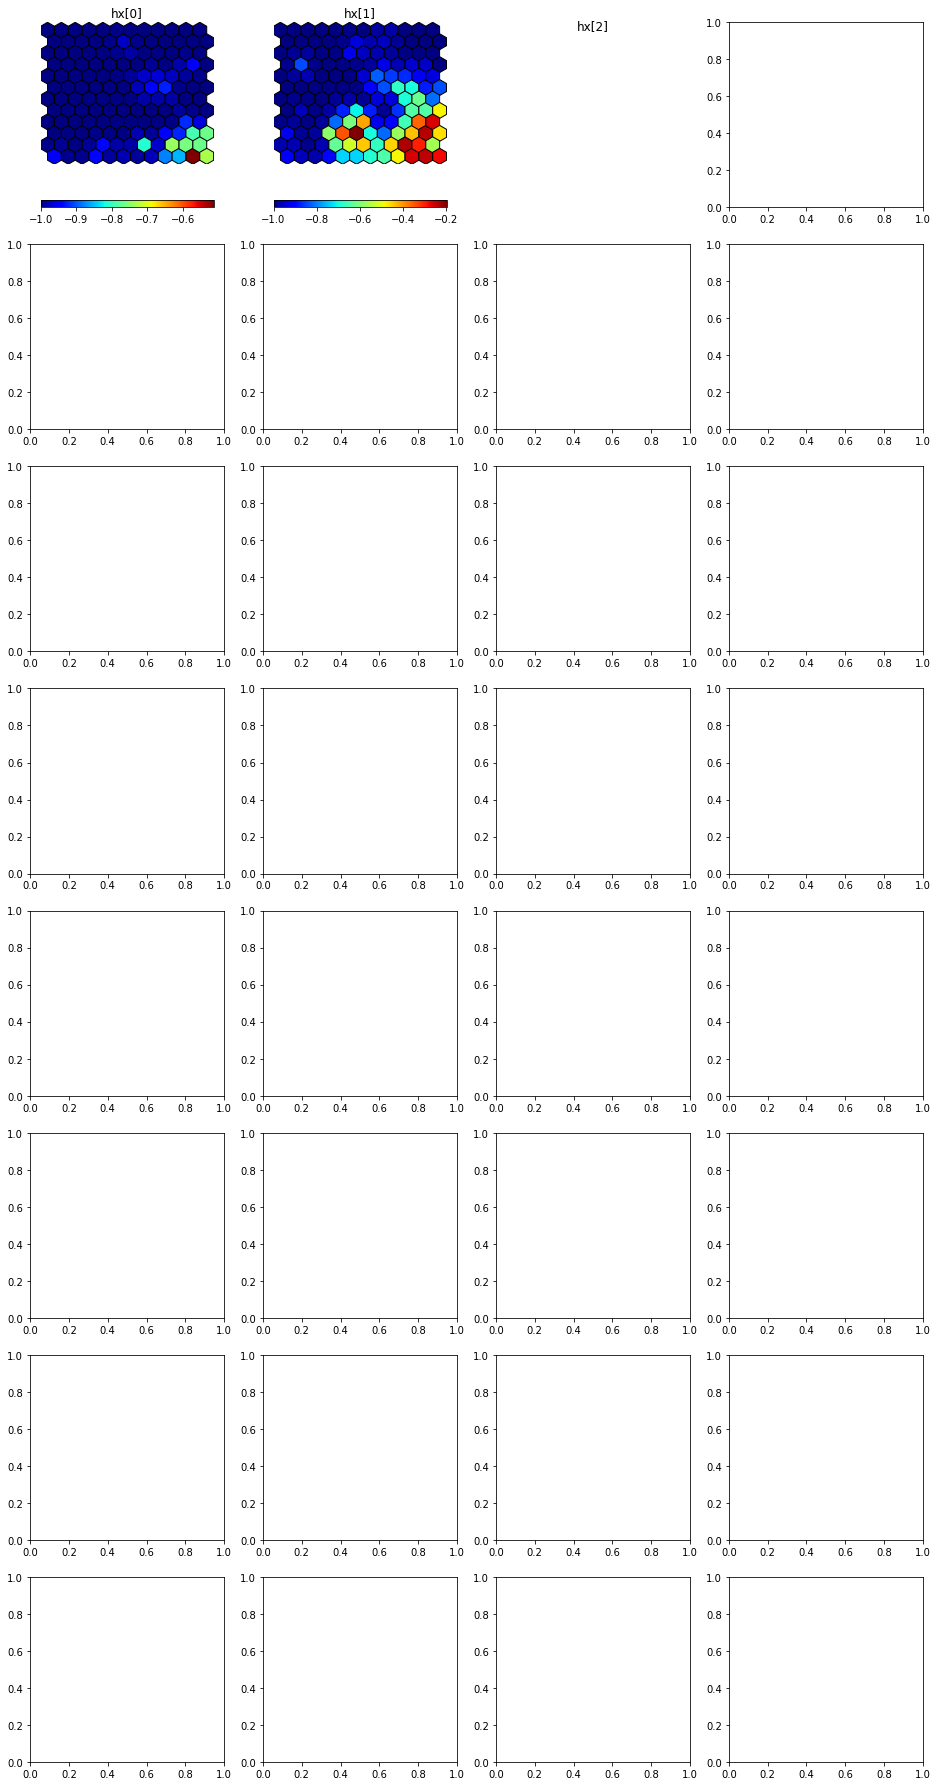

In [21]:
from mapview import View2D
dim = sData_train._dim
col_sz = 4
view2D  = View2D(16,4*(dim/col_sz),
                 "codage "+strChoix,
                 text_size=10)
view2D.show(sm, col_sz=col_sz, which_dim="all", denormalize=True) ; 

- **Affichage de la carte avec etiquettes (les indices des neurones)**

In [ ]:
view2D  = View2D(16,10,
                 "codage "+strChoix,
                 text_size=10) ;
view2D.show(sm, neuronLabels=None,anotate=True, col_sz=1, which_dim=1, denormalize=True, labelsize=16) ; 

 - **Affichage de la carte avec les cardinalités**

In [ ]:
from bmuhits import BmuHitsView
vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, logaritmic=False)

 - **Affichage de la carte (distances entre les référents/neurones)**

In [ ]:
from umatrix import UMatrixView
umat = UMatrixView(16,10,"Unified Distance Matrix", text_size=20)
umat.show(sm) ;

#### Evaluer l'apprentissage de la carte

* **Calcul des erreurs globales**

In [ ]:
topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error  = %s\nQuantization error = %s" % (topographic_error, quantization_error))

* **Coefficient de Silhouette**
(Pour cette partie on pourra voir la définition du [coefficient de Silhouette](https://fr.wikipedia.org/wiki/Silhouette_(clustering)) sur wikipedia ainsi que la documentation sur le site de scikit learn pour laquelle il y a un [tutoriel sur kmoyennes et silouhette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html))    
En partitionnement de données (clustering), le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données en classification automatique. Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation). Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.

Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. 

In [ ]:
# sm._bmu = sm._bmu[0].astype(int)

In [ ]:
silhouette_avg = silhouette_score(sm._data, sm._bmu[0].astype(int))
silhouette_avg

In [ ]:
sample_silhouette_values = coefficientSilhouette = silhouette_samples(sData_train._data, sm._bmu[0].astype(int))
# sample_silhouette_values

#### Labellisation des neurones référents à partir des labels des données

In [ ]:
sm.node_labels_from_data(sData_train)

In [ ]:
neuron_labels = np.array(sm.node_labels)
print(neuron_labels)

 - **Affichage de la carte avec etiquettes (les votes)**

In [ ]:
view2D  = View2D(16,10,
                 "codage "+strChoix,
                 text_size=10) ;
view2D.show(sm, neuronLabels=sm.node_labels,anotate=True, col_sz=1, which_dim=1, denormalize=True,labelsize=12) ; 

#### Classification Ascendante Hiérarchique
- **Affichage du dendrogramme des référents**

In [ ]:
from dendrogram import DendrogramView
dendrogram = DendrogramView(10,10,"Dendrogramme de l'arbre hierarchique", text_size = 10)
dendrogram.show(sm)

In [ ]:
from hitmap import HitMapView
hits  = HitMapView(16,10,"Clustering",text_size=10)
hits.show??

In [ ]:
from hitmap import HitMapView
sm.cluster(10)
hits  = HitMapView(16,10,"Clustering",text_size=10)
a=hits.show(sm,labelsize=20)

#### Un peu de supervisé (pas toujours possible)
Comme les données sont associées à des classes, nous allons en profiter pour voir la correspondance entre les classes issues de la carte (déduites uniquement des entrées de la carte) et celles fournies avec les données.    
**On rappelle qu'il s'agit d'un algorithme non supervisé.**    
Ainsi, on ne prend pas en compte les classes lors de l'apprentissage.    
**On cherche donc à évaluer la capacité de la carte à discriminer ces classes. Cela ne pourra être fait que si les données des différentes classes sont bien distinctes dans l'espace des données (i.e. les entrées de la carte).** 

**Détermination des indices des classes estimées et désirées**

On ajoute la classe de rejet

In [ ]:
classnames_ = classnames
classnames_.append('Nan')
classnames_ = np.array(classnames_)
classnames_

Détermination des indices des classes désirées

In [ ]:
_,classes_desirees = np.where(data_labels_train[:,None]==np.array(classnames)[None,:])
#classes_desirees

In [ ]:
neuron_labels[sm._bmu[0].astype(int)]

Par précaution, on recalcule les etiquettes des neurones

In [ ]:
# classes esimees
data_labels_estim = neuron_labels[sm._bmu[0].astype(int)]
_, classes_estimees = np.where(data_labels_estim[:,None]==np.array(classnames)[None,:])
#classes_estimees

**Matrice de confusion**

In [ ]:
plt.figure(figsize=(10,10)) 
plot_confusion_matrix(classes_desirees, classes_estimees, classnames_,
                          title='', fontsize=12) ;

In [ ]:
#Test

In [ ]:
_,classes_desirees = np.where(data_labels_val[:,None]==np.array(classnames)[None,:])


In [ ]:
sData_val = SOMData(data_val)
data_labels_estim =neuron_labels[sm.find_bmu(data_val).astype(int).T[:,0]]
_, classes_estimees = np.where(data_labels_estim[:,None]==np.array(classnames)[None,:])

In [ ]:
plt.figure(figsize=(10,10)) 
plot_confusion_matrix(classes_desirees, classes_estimees, classnames_,
                          title='', fontsize=12) ;

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(classes_desirees,classes_estimees)